# Part I - Environment Setup

We create the respective environment with all the necessary packages on my local machine

__conda activate ML_styleTransfer__

# Part II - ResNet-18 Backbone for Classification

We will start defining classifiers for the recognition of numbers on MNIST and SVHN.

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
from torchvision.models import Inception_V3_Weights
from torch.utils.data import DataLoader, Subset, TensorDataset,Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
import matplotlib.pyplot as plt
import cv2 as cv
import torch.optim as optim
from scipy.linalg import sqrtm
from PIL import Image
import gdown
import itertools
import torchvision.utils as vutils
import torch.nn.functional as F
from torchsummary import summary
import os
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.nn.functional import adaptive_avg_pool2d
import time
from torchvision.transforms.functional import to_pil_image

In [4]:
# seed for reproducibility
def set_seed(seed=101):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

##### __1. Implement a classifier of digits 0 to 9 that has as encoder backbone the ResNet-18 model. Tip: Please remember you should first remove the last fully connected layer of the pre-trained ResNet model and then add your own output layer for the classification with the desired number of classes. While this is trivial in Tensorflow, in Pytorch this is slightly more difficult. One simple change you can make is to simply modify the fc layer of your model accordingly. For checking the layers of your model you can use print(model). Please also have a look on this documentation on how to finetune common existing models: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html__

In [3]:
# Load pre-trained ResNet-18 model
resnet18_pretrained = models.resnet18(pretrained=True)
# I Remove the last fully connected layer (fc) and replace it with a new one for 10 classes
num_features = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_features, 10)

# Checking the modified model
print(resnet18_pretrained)

C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##### __2. Make the required changes either in the image loaders or in the network model such as that your model can process either images from MNIST and SVHN without changes.Please justify your choices.__

To handle both MNIST and SVHN datasets without changing the model or loaders, I made the following adjustments:

1. **Image Resizing and Grayscale Conversion**: Since MNIST images are 28x28 pixels and in grayscale, and SVHN images are 32x32 pixels and in color, the transform pipeline includes resizing and grayscale conversion. This ensures all images are of the same size (224x224, suitable for ResNet) and have three channels (grayscale images are converted to have three channels to mimic color images). 

2. **Justification**: 
    - **Resizing**: ResNet models are typically trained on ImageNet, which has images of size 224x224 pixels. Resizing MNIST and SVHN to this size allows the use of ResNet without structural changes.
    - **Grayscale Conversion**: Since MNIST is in grayscale and SVHN in color, converting MNIST images to 3-channel grayscale allows using the same network architecture designed for color images.

This approach simplifies the training pipeline by avoiding the need for separate models or complex loader logic for each dataset. It's a practical compromise between dataset consistency and model adaptability.

In [182]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224
    transforms.Grayscale(num_output_channels=3),  # Converting to 3-channel grayscale
    transforms.ToTensor()
])

# Load MNIST dataset
mnist_train_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_full = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Load SVHN dataset (for future use)
svhn_train = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [183]:
%pwd

'C:\\Users\\ksevi\\OneDrive\\Desktop\\MASTER\\THIRD SEMESTER\\MACHINE LEARNING -RENATO\\assignments2'

##### __3. Please define your loss using categorical cross-entropy (using softmax in your output layer). Make a training script to train your model using a global random seed of 101, with 6000 samples of MNIST, for 20 epochs, with a batch size 64, and Adam optimizer with learning rate of 0.001. Your test set should be using 1000 samples of the test set, and please select accuracy as your main metric for evaluation__

After dataset teatment we continue with the training with the following specifications ... __Continued__

In [184]:
mnist_train = Subset(mnist_train_full, torch.randperm(len(mnist_train_full))[:6000])
mnist_test = Subset(mnist_test_full, torch.randperm(len(mnist_test_full))[:1000])

train_loader_mnist = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [185]:
svhn_train_loader = DataLoader(svhn_train, batch_size=64, shuffle=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=64, shuffle=False)

##### __4. Please check and show the histogram of the classes of your cropped dataset. Are your datasets balanced?__

###### Dataset treatment

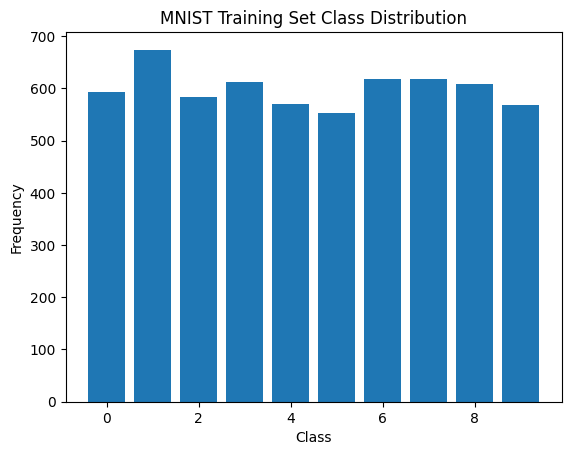

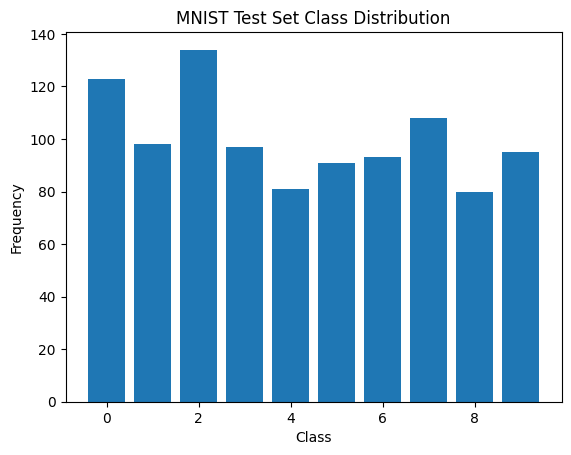

In [186]:
def plot_class_distribution(dataset, title):
    class_counts = [0] * 10  # Assuming 10 classes for MNIST digits
    for _, label in dataset:
        class_counts[label] += 1

    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    
# Plotting class distribution for MNIST datasets
plot_class_distribution(mnist_train, 'MNIST Training Set Class Distribution')
plot_class_distribution(mnist_test, 'MNIST Test Set Class Distribution')

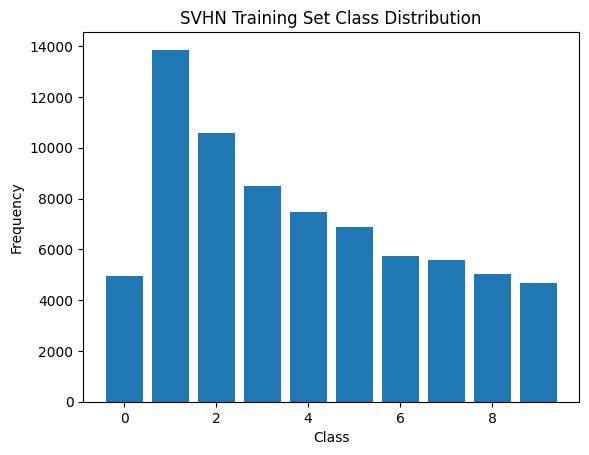

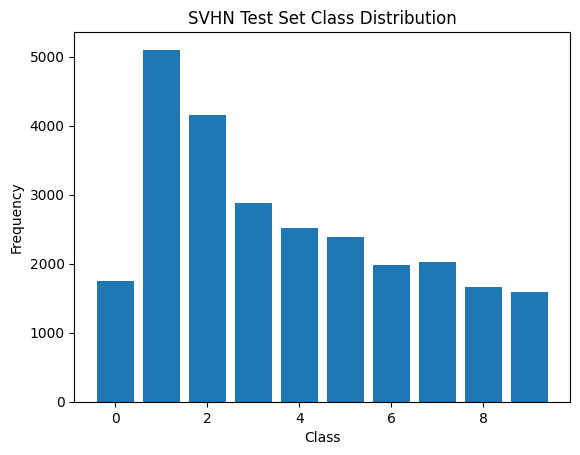

In [188]:
# Plotting class distribution for SVHN datasets
plot_class_distribution(svhn_train, 'SVHN Training Set Class Distribution')
plot_class_distribution(svhn_test, 'SVHN Test Set Class Distribution')

As you can see the MNIST dataset is balanced, but on the contrary the SVHN dataset is not, that is why the following preprocessing of the dataset

In [189]:
# Count the number of occurrences of each class in svhn_train 
class_counts = {}
for _, label in svhn_train:
    label = int(label)
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

#weights for each class
weights = [1.0 / class_counts[int(label)] for _, label in svhn_train]
sample_weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# DataLoader with the sampler
svhn_train_loader_balanced = DataLoader(svhn_train, batch_size=64, sampler=sampler)

In [190]:
# Count the number of occurrences of each class in svhn_test
class_counts = {}
for _, label in svhn_test:
    label = int(label)
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

#weights for each class
weights = [1.0 / class_counts[int(label)] for _, label in svhn_test]
sample_weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

#DataLoader with the sampler
svhn_test_loader_balanced = DataLoader(svhn_test, batch_size=64, sampler=sampler)

The balanced svhn dataset can already be displayed

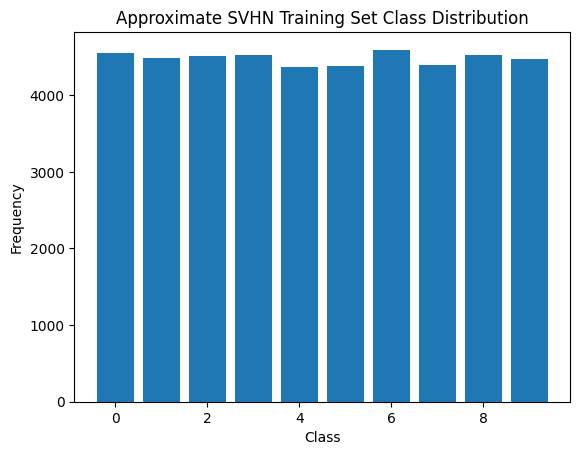

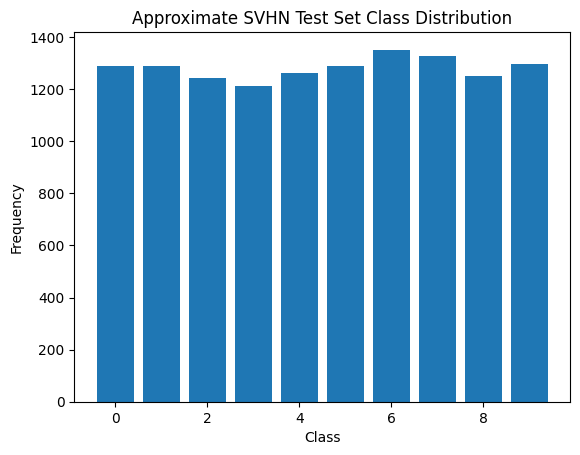

In [191]:
def plot_approximate_class_distribution(dataloader, num_batches, title):
    class_counts = [0] * 10  # Assuming 10 classes for SVHN digits
    for _ in range(num_batches):
        _, labels = next(iter(dataloader))
        labels = labels.numpy()
        for label in labels:
            class_counts[label] += 1

    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_approximate_class_distribution(svhn_train_loader_balanced,700,'Approximate SVHN Training Set Class Distribution')
plot_approximate_class_distribution(svhn_test_loader_balanced,200,'Approximate SVHN Test Set Class Distribution')

###### Continued

In [192]:
loss_fn = nn.CrossEntropyLoss()

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

def save_model(model, epoch, optimizer, path="best_model.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
                }, path)

def log_images(writer, images, epoch, tag='Train Images'):
    grid = torchvision.utils.make_grid(images)
    writer.add_image(tag, grid, epoch)

In [103]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, epochs=20, model_path="best_model.pth"):
    writer = SummaryWriter('runs/transfer_scratchbal_svhn') # I changed each time the name
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)    
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if i == 0: 
                log_images(writer, images, epoch)

        avg_train_loss = train_loss / len(train_loader.dataset)
        writer.add_scalar('Training Loss', avg_train_loss, epoch)

        model.eval()
        test_accuracy = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                test_accuracy += calculate_accuracy(outputs, labels)

        avg_test_accuracy = test_accuracy / len(test_loader)
        writer.add_scalar('Test Accuracy', avg_test_accuracy, epoch)

        if avg_test_accuracy > best_accuracy:
            best_accuracy = avg_test_accuracy
            save_model(model, epoch, optimizer, model_path)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")

    writer.close()
    return best_accuracy

In [95]:
optimizer_pretrained = optim.Adam(resnet18_pretrained.parameters(), lr=0.001)
train_and_evaluate(resnet18_pretrained, train_loader_mnist, test_loader_mnist, optimizer_pretrained, epochs=20, model_path="best_model_pret.pth")

Epoch 1/20, Training Loss: 0.0027, Test Accuracy: 0.9812
Epoch 2/20, Training Loss: 0.0008, Test Accuracy: 0.9824
Epoch 3/20, Training Loss: 0.0008, Test Accuracy: 0.9498
Epoch 4/20, Training Loss: 0.0007, Test Accuracy: 0.9828
Epoch 5/20, Training Loss: 0.0004, Test Accuracy: 0.9734
Epoch 6/20, Training Loss: 0.0003, Test Accuracy: 0.9824
Epoch 7/20, Training Loss: 0.0004, Test Accuracy: 0.9854
Epoch 8/20, Training Loss: 0.0003, Test Accuracy: 0.9902
Epoch 9/20, Training Loss: 0.0003, Test Accuracy: 0.9818
Epoch 10/20, Training Loss: 0.0004, Test Accuracy: 0.9857
Epoch 11/20, Training Loss: 0.0003, Test Accuracy: 0.9912
Epoch 12/20, Training Loss: 0.0001, Test Accuracy: 0.9893
Epoch 13/20, Training Loss: 0.0001, Test Accuracy: 0.9902
Epoch 14/20, Training Loss: 0.0000, Test Accuracy: 0.9902
Epoch 15/20, Training Loss: 0.0000, Test Accuracy: 0.9912
Epoch 16/20, Training Loss: 0.0000, Test Accuracy: 0.9912
Epoch 17/20, Training Loss: 0.0000, Test Accuracy: 0.9922
Epoch 18/20, Training L

0.9921875

<img src="preresnet1.png" width="400" />

In [193]:
resnet18_scratch = models.resnet18(weights=None)#pretrained=False
resnet18_scratch.fc = nn.Linear(num_features, 10)
print(resnet18_scratch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [98]:
optimizer_scratch = optim.Adam(resnet18_scratch.parameters(), lr=0.001)
train_and_evaluate(resnet18_scratch, train_loader_mnist, test_loader_mnist, optimizer_scratch, epochs=20, model_path="best_model_scratch.pth")

Epoch 1/20, Training Loss: 0.0057, Test Accuracy: 0.5869
Epoch 2/20, Training Loss: 0.0017, Test Accuracy: 0.9520
Epoch 3/20, Training Loss: 0.0014, Test Accuracy: 0.9775
Epoch 4/20, Training Loss: 0.0009, Test Accuracy: 0.9451
Epoch 5/20, Training Loss: 0.0008, Test Accuracy: 0.9721
Epoch 6/20, Training Loss: 0.0005, Test Accuracy: 0.8932
Epoch 7/20, Training Loss: 0.0005, Test Accuracy: 0.9854
Epoch 8/20, Training Loss: 0.0005, Test Accuracy: 0.9887
Epoch 9/20, Training Loss: 0.0002, Test Accuracy: 0.9844
Epoch 10/20, Training Loss: 0.0002, Test Accuracy: 0.9912
Epoch 11/20, Training Loss: 0.0003, Test Accuracy: 0.9881
Epoch 12/20, Training Loss: 0.0002, Test Accuracy: 0.9912
Epoch 13/20, Training Loss: 0.0001, Test Accuracy: 0.9854
Epoch 14/20, Training Loss: 0.0001, Test Accuracy: 0.9033
Epoch 15/20, Training Loss: 0.0002, Test Accuracy: 0.9750
Epoch 16/20, Training Loss: 0.0002, Test Accuracy: 0.9844
Epoch 17/20, Training Loss: 0.0001, Test Accuracy: 0.9932
Epoch 18/20, Training L

0.9931640625

<img src="scratchresnet1.png" width="400" />

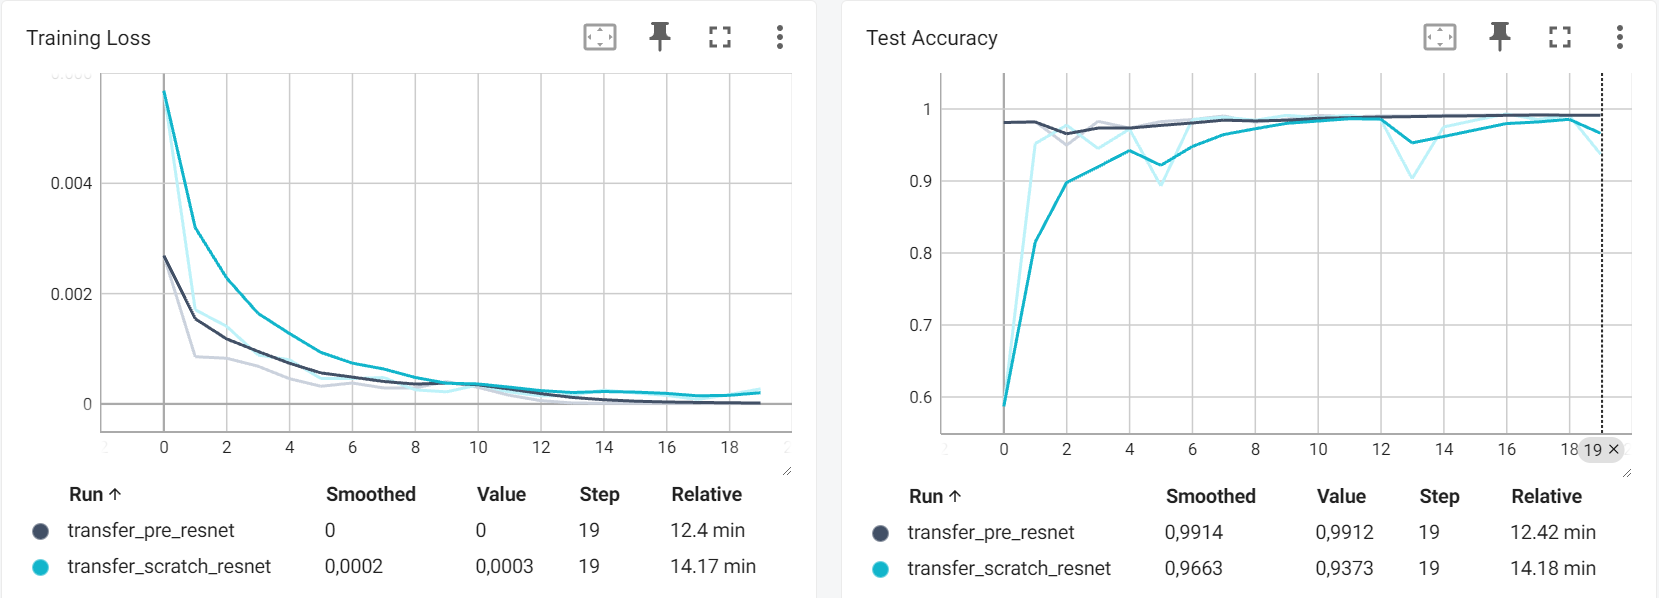

In [102]:
optimizer_pretrained = optim.Adam(resnet18_pretrained.parameters(), lr=0.001)
train_and_evaluate(resnet18_pretrained, svhn_train_loader_balanced, svhn_test_loader_balanced, optimizer_pretrained, epochs=20, model_path="best_model_pretbal_svhn.pth")

Epoch 1/20, Training Loss: 0.0005, Test Accuracy: 0.9490
Epoch 2/20, Training Loss: 0.0005, Test Accuracy: 0.9522
Epoch 3/20, Training Loss: 0.0004, Test Accuracy: 0.9429
Epoch 4/20, Training Loss: 0.0004, Test Accuracy: 0.9492
Epoch 5/20, Training Loss: 0.0004, Test Accuracy: 0.9541
Epoch 6/20, Training Loss: 0.0003, Test Accuracy: 0.9536
Epoch 7/20, Training Loss: 0.0003, Test Accuracy: 0.9453
Epoch 8/20, Training Loss: 0.0002, Test Accuracy: 0.9476
Epoch 9/20, Training Loss: 0.0003, Test Accuracy: 0.9526
Epoch 10/20, Training Loss: 0.0002, Test Accuracy: 0.9521
Epoch 11/20, Training Loss: 0.0002, Test Accuracy: 0.9517
Epoch 12/20, Training Loss: 0.0002, Test Accuracy: 0.9463
Epoch 13/20, Training Loss: 0.0002, Test Accuracy: 0.9524
Epoch 14/20, Training Loss: 0.0002, Test Accuracy: 0.9510
Epoch 15/20, Training Loss: 0.0002, Test Accuracy: 0.9486
Epoch 16/20, Training Loss: 0.0002, Test Accuracy: 0.9525
Epoch 17/20, Training Loss: 0.0001, Test Accuracy: 0.9469
Epoch 18/20, Training L

0.9565161752661753

<img src="presvhn1.png" width="400" />

In [104]:
optimizer_scratch = optim.Adam(resnet18_scratch.parameters(), lr=0.001)
train_and_evaluate(resnet18_scratch, svhn_train_loader_balanced, svhn_test_loader_balanced, optimizer_scratch, epochs=20, model_path="best_model_scratchbal_svhn.pth")

Epoch 1/20, Training Loss: 0.0070, Test Accuracy: 0.8833
Epoch 2/20, Training Loss: 0.0036, Test Accuracy: 0.9245
Epoch 3/20, Training Loss: 0.0029, Test Accuracy: 0.9357
Epoch 4/20, Training Loss: 0.0023, Test Accuracy: 0.9427
Epoch 5/20, Training Loss: 0.0019, Test Accuracy: 0.9481
Epoch 6/20, Training Loss: 0.0016, Test Accuracy: 0.9440
Epoch 7/20, Training Loss: 0.0013, Test Accuracy: 0.9379
Epoch 8/20, Training Loss: 0.0009, Test Accuracy: 0.9303
Epoch 9/20, Training Loss: 0.0009, Test Accuracy: 0.9469
Epoch 10/20, Training Loss: 0.0007, Test Accuracy: 0.9405
Epoch 11/20, Training Loss: 0.0006, Test Accuracy: 0.9387
Epoch 12/20, Training Loss: 0.0005, Test Accuracy: 0.9477
Epoch 13/20, Training Loss: 0.0004, Test Accuracy: 0.9496
Epoch 14/20, Training Loss: 0.0004, Test Accuracy: 0.9470
Epoch 15/20, Training Loss: 0.0004, Test Accuracy: 0.9420
Epoch 16/20, Training Loss: 0.0003, Test Accuracy: 0.9499
Epoch 17/20, Training Loss: 0.0003, Test Accuracy: 0.9391
Epoch 18/20, Training L

0.9499129811629811

<img src="scratchsvhn1.png" width="400" />

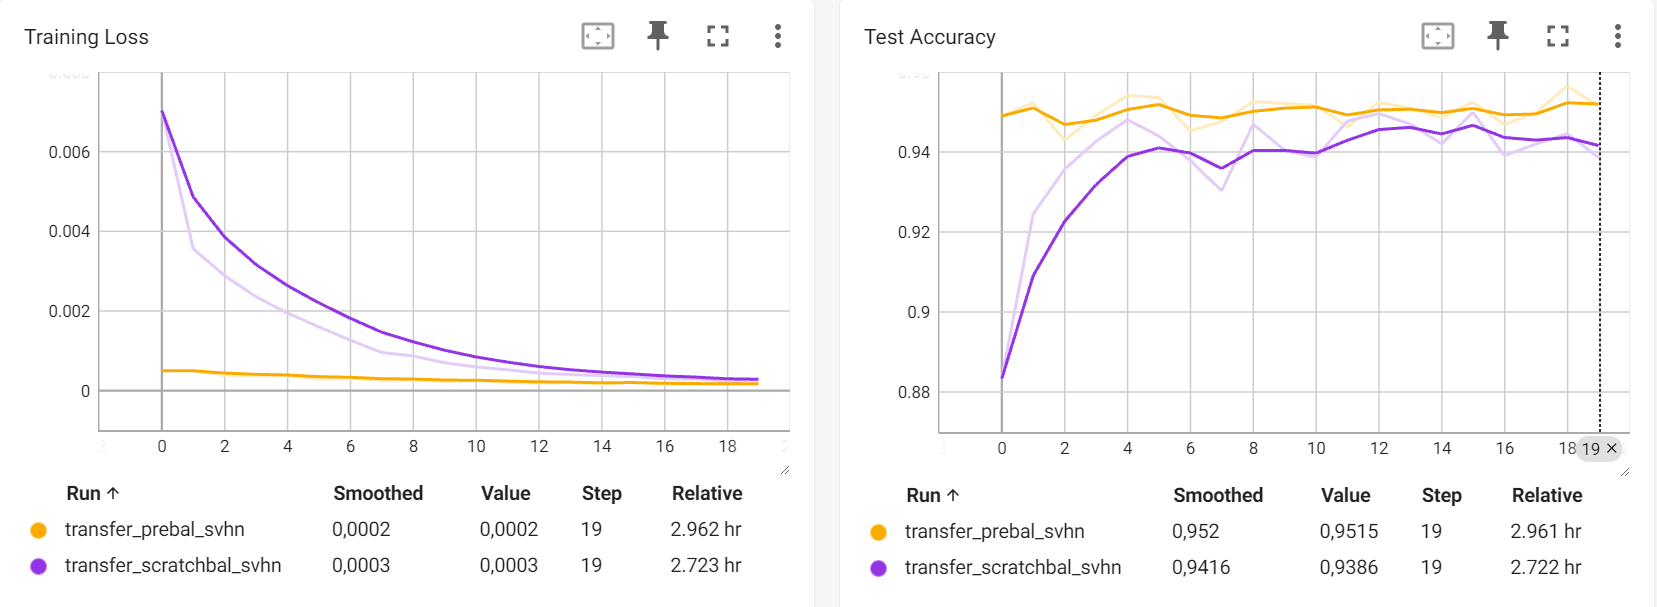

##### __5. Define two versions of your model, one that reuses the pre-trained weights of ResNet-18 and another trained from scratch. What are the classification accuracies on MNIST of both models? What are the classification accuracies on SVHN of both models?__

Comparison of Accuracy on MNIST:

    Pre-trained model: Achieves a maximum accuracy of 0.9912.
    Model trained from scratch: Achieves a maximum accuracy of 0.9932.

Comparison of Accuracy on SVHN:

    Pre-trained model: Achieves a maximum accuracy of 0.9565.
    Model trained from scratch: Achieves a maximum accuracy of 0.9499.


 __Which dataset is easier to be classified and what is the configuration you would keep?__
 
MNIST appears to be easier to classify than SVHN, as both the pre-trained and scratch-trained models achieved higher accuracies on the MNIST dataset

        For MNIST, the model trained from scratch shows a slight improvement in accuracy compared to the pre-trained model. However, the difference is minimal and might not justify the additional training cost, especially considering the training time (14.17 minutes for scratch vs. 12.4 minutes for pre-trained).
        For SVHN, the pre-trained model outperforms the scratch-trained model in terms of accuracy, though by a small      margin. However, the training time is significantly longer for the pre-trained model (2.962 hours) compared to the     scratch-trained model (2.723 hours).

In summary, using pre-trained models seems to be a good choice in terms of balancing accuracy and training time, especially for SVHN. For MNIST, the scratch-trained model has a slight edge in accuracy, but one needs to consider whether the additional training time is worth it. In a production or research scenario where time and resources are crucial factors, the pre-trained model might be preferred due to its time efficiency.

##### __6. Do you observe any underfitting or overfitting in the obtained training loss and metrics curves?__

For both the MNIST and SVHN datasets, there are no clear indicators of underfitting or overfitting. Both models have learned the respective datasets effectively, with the pre-trained models showing a slight edge in terms of starting from a better point and achieving slightly higher test accuracy. The training process appears to be stable and well-tuned for both datasets.

# Part III - Image-to-Image Translation

You will now design the CycleGAN model and evaluate the performance of your model for style
transfer (aka as image-to-image translation), changing images from MNIST to look colored, or
like as in SVHN. You will also test different ways to evaluate the performance of your model.

##### __1. Write your own function compute FID that receives two sets of data samples and returns the Frechet Inception Distance between the images in them. The Frechet inception distance measures the Frechet distance between two Gaussian distributions from the averaged features extracted using the inceptionv3 network. Please note you should implement your own FID metric using these definitions. You should however use the pre-trained inception v3 model available on Pytorch for feature extraction. Tips: Please notice you can remove the last fully connected layer by replacing it with an nn.Identity() layer. For the preprocessing of the input data expected by inceptionv3 you can use the following:__


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_fid(images1, images2, model_inception, batch_size=64):
    model_inception.to(device)
    model_inception.eval()

    def extract_features(images):
        features = []
        for i in range(0, images.size(0), batch_size):
            image_batch = images[i:i + batch_size].to(device)
            with torch.no_grad():
                feature = model_inception(image_batch)
            features.append(feature.cpu())
        features = torch.cat(features, dim=0).numpy()
        return features

    features1 = extract_features(images1)
    features2 = extract_features(images2)

    mu1, sigma1 = features1.mean(axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = features2.mean(axis=0), np.cov(features2, rowvar=False)

    # Agregar un pequeño valor a la diagonal de las matrices de covarianza
    epsilon = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * epsilon
    sigma2 += np.eye(sigma2.shape[0]) * epsilon

    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [28]:
# Carga el modelo InceptionV3
model_inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_inception.fc = torch.nn.Identity()
model_inception = model_inception.to(device)
model_inception.eval()

Using cache found in C:\Users\ksevi/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

##### 2. In order to evaluate your FID implementation, please compute the FID from the provided set of colored images generated with a previously learned CycleGAN model:

In [6]:
%pwd

'C:\\Users\\ksevi\\OneDrive\\Desktop\\MASTER\\THIRD SEMESTER\\MACHINE LEARNING -RENATO\\assignments2'

In [50]:
#%cd C:\\Users\\ksevi\\OneDrive\\Desktop\\MASTER\\THIRD SEMESTER\\MACHINE LEARNING -RENATO\\assignments2

C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments2


In [68]:
#!mkdir data
#%cd data
#!gdown https://drive.google.com/uc?id=16TdnYC1kCpKVR7yu8y8A-AvElvaQheOu

C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments2\data


In [5]:
# convert MNIST to color images
def get_rgb ( images_src , image_labels ):
    colored_images = np.zeros(( images_src.shape [0] , 28, 28, 3))
    """ Convert the digits to specific colored - version .
    0: red ; 1: blue ; 2: green ; 3: violet ; 4: purple ; 5: pink ;
    6: orange ; 7: yellow ; 8: brown ; 9: cornflower blue . """
    colors = np.array (
                        [[255 , 0, 0],
                        [135 , 206 , 235] ,
                        [ 0, 128 , 0],
                        [238 , 130 , 238] ,
                        [128 , 0, 128] ,
                        [255 , 192 , 203] ,
                        [255 , 128 , 0],
                        [255 , 255 , 0],
                        [165 , 42, 42] ,
                        [100 , 149 , 237]] , np.float32 )
    

    for k in range ( images_src.shape [0]) :
        for i in range (28) :
            for j in range (28) :
                if images_src [k][i][j] > 0:
                    colored_images [k][i][j][:] = colors[int (image_labels [k])]
    return colored_images/255

In [7]:
%pwd

'C:\\Users\\ksevi\\OneDrive\\Desktop\\MASTER\\THIRD SEMESTER\\MACHINE LEARNING -RENATO\\assignments2'

In [7]:
# ###########################################
### Create colored MNIST data ###
# ###########################################
## Dataset preparation
# number of images to process
img_number = 1000
index_sub = np.arange(img_number)

# slicing dataset
#mnist_train_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

dataset_mnist = datasets.MNIST ( root ='./data1', train =True , download = True )
#dataset_mnist = mnist_train_full
dataset_mnist.data = dataset_mnist.data [ index_sub ]
dataset_mnist.targets = dataset_mnist.targets [ index_sub ]
images_np = dataset_mnist.data.numpy()
labels_np = dataset_mnist.targets.numpy()

In [8]:
images_np = images_np.reshape(-1, 28, 28).astype(np.float32)  # Reshape if needed
colored_real = get_rgb(images_np, labels_np)
colored_real = torch.tensor(colored_real)

torch.Size([64, 3, 28, 28])


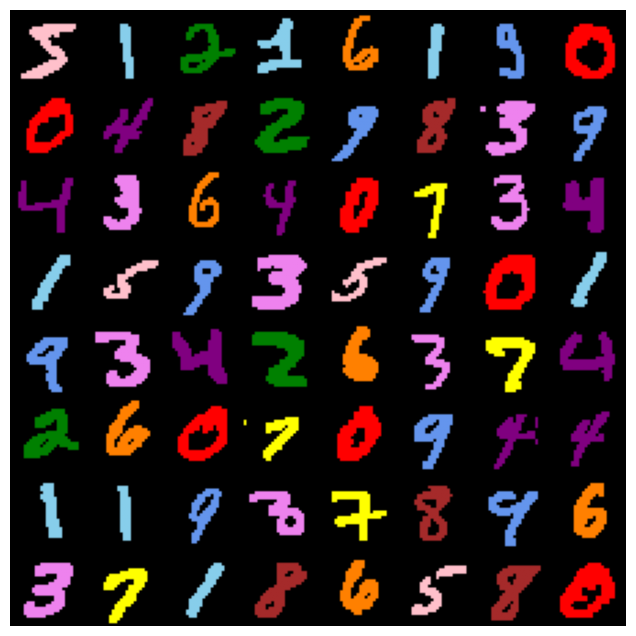

In [9]:
plt.figure ( figsize =(8 ,8) )
plotviews = colored_real [0:64 ,: ,: ,:]
plotviews = torch.swapaxes( plotviews ,1 ,3)
print( plotviews.shape )
plt.axis("off")
plt.imshow(np.transpose( vutils.make_grid( plotviews , padding =0, normalize = True).cpu() ,(2 ,1 ,0)))

In [10]:
colored_real_copia = colored_real.clone().detach()
colored_real = colored_real_copia.permute(0, 3, 1, 2)  # Cambiar la forma a (N, C, H, W)

In [11]:
colored_real.shape

torch.Size([1000, 3, 28, 28])

In [12]:
%pwd

'C:\\Users\\ksevi\\OneDrive\\Desktop\\MASTER\\THIRD SEMESTER\\MACHINE LEARNING -RENATO\\assignments2'

torch.Size([64, 3, 28, 28])


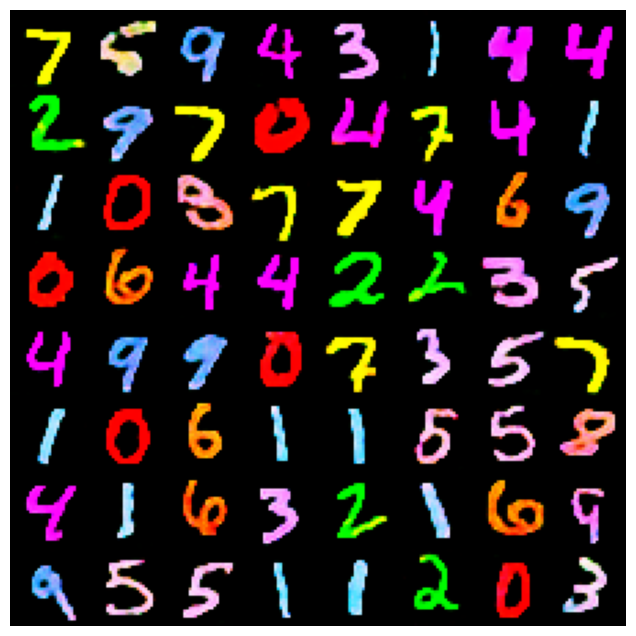

In [12]:
# ###########################################
### Generated data with CycleGAN ###
# ###########################################
## data MNIST X_test using CycleGAN
with open ('data/data_sem.npy', 'rb') as f:
    colored_cycle = np.load(f)

colored_cycle = colored_cycle [0: img_number ,]

plt.figure( figsize =(8 ,8) )
plotviews = colored_cycle [0:64 ,: ,: ,:]
plotviews = torch.tensor(plotviews)
plotviews = torch.swapaxes(plotviews,1 ,3)
print(plotviews.shape)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid( plotviews , padding =0).cpu (),(2 ,1 ,0)))    

In [13]:
colored_cycle = torch.tensor(colored_cycle).permute(0, 3, 1, 2)  # Change shape to (N, C, H, W)

In [14]:
colored_cycle.shape 

torch.Size([1000, 3, 28, 28])

Compute FID for each scenario

###### • Domain A: real colored MNIST and domain B: generated colored MNIST

In [15]:
# Normalizo los datos al rango [0, 1]
colored_cycle = colored_cycle.float() / 255.0

In [16]:
class ColoredMNISTDataset(Dataset):
    def __init__(self, images):
        self.images = images
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  
            transforms.Resize((299, 299)),  # Redimensionar para InceptionV3
            transforms.ToTensor(),  
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)  # Aplicar transformaciones
        return image

In [17]:
dataset_real = ColoredMNISTDataset(colored_real)

In [18]:
dataset_generated = ColoredMNISTDataset(colored_cycle)

In [19]:
batch_size = 64 
dataloader_real = DataLoader(dataset_real, batch_size=batch_size, shuffle=False)
dataloader_generated = DataLoader(dataset_generated, batch_size=batch_size, shuffle=False)

In [20]:
def get_all_images(dataloader):
    images = []
    for image_batch in dataloader:
       # print("Shape of batch:", image_batch.shape)
        images.append(image_batch)
    images = torch.cat(images, dim=0)  # Concatenate all batches
    return images

In [21]:
images_real = get_all_images(dataloader_real)
images_generated = get_all_images(dataloader_generated)

In [22]:
images_real.shape

torch.Size([1000, 3, 299, 299])

In [23]:
images_generated.shape

torch.Size([1000, 3, 299, 299])

In [24]:
dataiter = iter(images_generated)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -1.5523005723953247
Desviación estándar del lote: 1.1875282526016235
Mínimo valor en el lote: -2.1179039478302
Máximo valor en el lote: 2.4110641479492188


In [25]:
dataiter = iter(images_real)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -1.1908841133117676
Desviación estándar del lote: 1.4421885013580322
Mínimo valor en el lote: -2.1179039478302
Máximo valor en el lote: 2.248908281326294


In [441]:
import gc
del dataloader_real
gc.collect()  
torch.cuda.empty_cache() 

In [29]:
# Calcula FID
fid_value = compute_fid(images_real, images_generated, model_inception, batch_size=64)

print(f"FID Real Colored MNIST vs. Generated Colored MNIST : {fid_value}")

FID Real Colored MNIST vs. Generated Colored MNIST : 47.91797194680662


###### • Domain A: Original MNIST (first 1000 images of the test set) and domain B: generated colored MNIST

In [30]:
dataset_mnist_test = datasets.MNIST ( root ='./data2', train =False , download = True )
mnist_test_first_1000 = Subset(dataset_mnist_test, range(1000))

In [31]:
class MNISTColoredDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),  # Redimensionar para InceptionV3
            transforms.Grayscale(num_output_channels=3),  # Convertir a 3 canales
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[idx]
        # Aplicar transformaciones
        image = self.transform(image)
        return image

In [32]:
dataset_mnist_colored = MNISTColoredDataset(mnist_test_first_1000) #DIMENSION Inception
dataloader_mnist_colored = DataLoader(dataset_mnist_colored, batch_size=64, shuffle=False)

images_mnist_colored_1000 = get_all_images(dataloader_mnist_colored).to(device)

In [33]:
dataiter = iter(images_mnist_colored_1000)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -1.5775336027145386
Desviación estándar del lote: 1.0673476457595825
Mínimo valor en el lote: -2.1179039478302
Máximo valor en el lote: 2.6225709915161133


In [34]:
images_mnist_colored_1000.shape

torch.Size([1000, 3, 299, 299])

In [35]:
images_generated.shape

torch.Size([1000, 3, 299, 299])

In [36]:
# Calcula FID
fid_value = compute_fid(images_mnist_colored_1000, images_generated, model_inception, batch_size=64)

print(f"FID between Original MNIST (first 1000 images of the test set) vs. Generated Colored MNIST: {fid_value}")

FID between Original MNIST (first 1000 images of the test set) vs. Generated Colored MNIST: 160.60857393641


In [309]:
#import gc
#del images_mnist_colored_1000, images_generated  # Elimina las variables que ya no son necesarias
#gc.collect()  # Recolección de basura (Python)
#torch.cuda.empty_cache() 

579

###### • Domain A: Original MNIST (first 500 images of the test set) and domain B: first 500 images of training set of SVHN

In [37]:
mnist_test_first_500 = Subset(dataset_mnist_test, range(500)) 
dataset_mnist_colored_500 = MNISTColoredDataset(mnist_test_first_500) #dimension inception
dataloader_mnist_colored_500 = DataLoader(dataset_mnist_colored_500, batch_size=64, shuffle=False)
images_mnist_colored_500 = get_all_images(dataloader_mnist_colored_500).to(device)

In [38]:
def get_all_images_svhn(dataloader):
    images = []
    for image_batch in dataloader: 
        #print(f"Forma del lote en get_all_images_svhn: {image_batch.shape}")  # Debería ser (batch_size, C, H, W)
        images.append(image_batch)
    images = torch.cat(images, dim=0)  # Concatenar todos los lotes
    return images

In [39]:
svhn = datasets.SVHN(root='./data_svhn1', split='train', download=True)
svhn_data = svhn.data

if svhn_data.max() > 1:
    # Asegúrate de que los datos estén en el rango [0, 1]
    svhn_data = svhn_data.astype(np.float32) / 255.0

# 2. Transformar y Cargar los Datos
transform_svhn = transforms.Compose([
    transforms.Resize((299, 299)),  # Redimensionar para InceptionV3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización para InceptionV3
])
class CustomSVHNDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].transpose((1, 2, 0))
        #print(f"Forma después de transpose: {image.shape}")  # Debería ser (H, W, C)

        image = Image.fromarray((image * 255).astype(np.uint8))
        #print(f"Forma después de convertir a PIL: {np.array(image).shape}")  # Debería ser (H, W, C)

        if self.transform:
            image = self.transform(image)
            #print(f"Forma después de transformaciones: {image.shape}")  # Debería ser (C, H, W)
        return image

Using downloaded and verified file: ./data_svhn1\train_32x32.mat


In [352]:
#import gc
#del svhn  # Elimina las variables que ya no son necesarias
#gc.collect()  # Recolección de basura (Python)
#torch.cuda.empty_cache() 

In [40]:
# Crear un conjunto de datos personalizado y un cargador de datos
dataset_svhn_custom = CustomSVHNDataset(svhn_data, transform=transform_svhn)
svhn_first_500 = Subset(dataset_svhn_custom, range(500))  # Tomar los primeros 500
dataloader_svhn_500 = DataLoader(svhn_first_500, batch_size=64, shuffle=False)

In [41]:
dataiter = iter(dataloader_svhn_500)
images = next(dataiter) 
print(f"Forma de las imágenes del DataLoader: {images.shape}")  # Debería ser algo como (batch_size, C, H, W)

Forma de las imágenes del DataLoader: torch.Size([64, 3, 299, 299])


In [42]:
images_svhn_500_train = get_all_images_svhn(dataloader_svhn_500).to(device)
print(f"Forma de images_svhn_500_train: {images_svhn_500_train.shape}")

Forma de images_svhn_500_train: torch.Size([500, 3, 299, 299])


In [43]:
dataiter = iter(images_mnist_colored_500)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -1.5775336027145386
Desviación estándar del lote: 1.0673476457595825
Mínimo valor en el lote: -2.1179039478302
Máximo valor en el lote: 2.6225709915161133


In [45]:
dataiter = iter(images_svhn_500_train)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -0.8840353488922119
Desviación estándar del lote: 0.41557636857032776
Mínimo valor en el lote: -1.9124069213867188
Máximo valor en el lote: -0.14495795965194702


In [44]:
images_mnist_colored_500.shape

torch.Size([500, 3, 299, 299])

In [46]:
fid_value = compute_fid(images_mnist_colored_500 , images_svhn_500_train, model_inception,batch_size=64)
print(f"FID between MNIST (test set, first 500) and SVHN (training set, first 500): {fid_value}")

FID between MNIST (test set, first 500) and SVHN (training set, first 500): 220.20525534721608


In [477]:
#del images_mnist_colored_500, images_svhn_500 # Elimina las variables que ya no son necesarias
#gc.collect()  # Recolección de basura (Python)
#torch.cuda.empty_cache() 

In [483]:
#del dataset_svhn 
#gc.collect()  
#torch.cuda.empty_cache() 
#tensorboard --logdir=./

__Which one presents the smallest FID and highest FID? Comment and analyse the results
from what you would expect.__

    Real Colored MNIST (created by get_rgb) vs. CycleGAN Generated Colored MNIST (FID: 47.91):
The lowest FID score, indicating CycleGAN's effective capture of the Real Colored MNIST's distribution, closely aligning generated images with real ones in statistical properties and preserving key features like shapes and colors.

    Original MNIST (first 1000 images of the test set) vs. CycleGAN Generated Colored MNIST (FID: 160.60):

Higher FID score due to color space differences, with CycleGAN's colorization introducing variations absent in the original grayscale MNIST, affecting the FID score by highlighting the role of color features

    MNIST (test set, first 500) vs. SVHN (training set, first 500) (FID: 220.21):
The highest FID score, reflecting the contrast between MNIST's grayscale digits and SVHN's colorful, complex backgrounds, attributed to disparities in context, texture, and style, underscoring the challenges in comparing fundamentally different datasets.

FID scores reflect differences in image quality and inherent data characteristics, showing models' effectiveness in capturing target dataset distributions with variations in source and target data influencing FID values. 


Note! : In this part I want to emphasize that it took me much more time to try to have proper FID results for each of the dataset comparisons (many times I got negative, complex or too high results), many times it was because the normalization was not good, or did not fit with the inception model, that's why you can see that I constantly check that detail, as well as having to clean my memory constantly. 

##### __3. Please see the GAN notebook and model seen during the lecture (DL GAN DemoGeneration.ipynb and slides) to help implementing a training loop of a GAN model. Then implement your CycleGAN model for changing the style of MNIST images. Please notice your two generators now should follow an encoder-decoder structure. Please select a U-Net encoder-decoder for your generator (as seen during the class) taking care of the number of parameters of your overall model. Please comment and justify your design choices.__

In [47]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),#nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),#nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),#nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)

In [48]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.down1 = ConvBlock(in_channels, 32)
        self.down2 = ConvBlock(32, 64)
        
        self.bottleneck = ConvBlock(64, 128)
        
        self.up1 = UpConv(128, 64)
        self.conv1 = ConvBlock(128, 64)
        self.up2 = UpConv(64, 32)
        self.conv2 = ConvBlock(64, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, 2))
        x5 = self.bottleneck(F.max_pool2d(x2, 2))
        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x2], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x1], dim=1))
        return self.final(x)

In [49]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)  # Output layer
        )

    def forward(self, x):
        return self.model(x)

In [97]:
def weights_init(m, visited=None):
    if visited is None:
        visited = set()
    if m in visited:
        return
    visited.add(m)
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
        if m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif hasattr(m, 'children') and len(list(m.children())) > 0:
        for sub_module in m.children():
            weights_init(sub_module, visited)

In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#hid_channels=32

In [99]:
# Initialize the generators
G_AB = UNetGenerator(in_channels=1, out_channels=3).to(device)  # MNIST to Colored MNIST (1 channel to 3 channels)
G_BA = UNetGenerator(in_channels=3, out_channels=1).to(device)  # Colored MNIST to MNIST (3 channels to 1 channel)

# Initialize the discriminators
D_A = Discriminator(in_channels=1).to(device)  # For grayscale images
D_B = Discriminator(in_channels=3).to(device)  # For colored images

In [9]:
# Apply weights initialization
G_AB.apply(weights_init)
G_BA.apply(weights_init)

UNetGenerator(
  (down1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (down2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (bottleneck): ConvBlock(
    (conv): Sequential(
      (0): 

In [10]:
D_A.apply(weights_init)
D_B.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

U-Net Architecture for Generators:

    Why U-Net?: U-Net's encoder-decoder structure with skip connections is effective for style transfer tasks. It allows     the model to carry context information from the encoder to the decoder, helping in better preserving the structure of  the input image while altering its style.
    Modifications for MNIST: Given the relatively simple structure of MNIST images, the depth of layers in U-Net can be       reduced to avoid overfitting and reduce computational load.

In [11]:
# Adversarial Loss
criterion_GAN = nn.MSELoss()
# Cycle Consistency Loss
criterion_cycle = nn.L1Loss()
# Identity Loss
criterion_identity = nn.L1Loss()

In [12]:
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Lambda weight for cycle consistency loss
lambda_cycle = 10

# Lambda weight for identity loss 
lambda_identity = 0.4 #svhn 0.6 , 0.4 mnist
#num_epochs = 250

In [13]:
# Optimizers for the generators and discriminators
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
#scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.4)
#scheduler_D_A = torch.optim.lr_scheduler.StepLR(optimizer_D_A, step_size=50, gamma=0.4)
#scheduler_D_B = torch.optim.lr_scheduler.StepLR(optimizer_D_B, step_size=50, gamma=0.4)

In [14]:
#función para ver todo
def summarize_models(generator, discriminator, input_size):
    print("*" * 100)
    print("CycleGAN's Generator And Discriminator Summary".center(100))
    print("*" * 100 + "\n\n")

    print("*" * 100)
    print("Generator Summary".center(100))
    print("*" * 100)
    print(summary(generator, input_size))
    print("\n\n" + "*" * 100)
    print("Discriminator Summary".center(100))
    print("*" * 100)
    print(summary(discriminator, input_size))

In [15]:
summarize_models(G_AB, D_A, input_size=(1, 128, 128))

****************************************************************************************************
                           CycleGAN's Generator And Discriminator Summary                           
****************************************************************************************************


****************************************************************************************************
                                         Generator Summary                                          
****************************************************************************************************
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
    InstanceNorm2d-2         [-1, 32, 128, 128]               0
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
    Ins

In [16]:
summarize_models(G_BA, D_B, input_size=(3, 128, 128))

****************************************************************************************************
                           CycleGAN's Generator And Discriminator Summary                           
****************************************************************************************************


****************************************************************************************************
                                         Generator Summary                                          
****************************************************************************************************
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
    InstanceNorm2d-2         [-1, 32, 128, 128]               0
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
    Ins

In [27]:
def save_checkpoint(epoch, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B):
    torch.save({
        'epoch': epoch,
        'G_AB_state_dict': G_AB.state_dict(),
        'G_BA_state_dict': G_BA.state_dict(),
        'D_A_state_dict': D_A.state_dict(),
        'D_B_state_dict': D_B.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
    }, f'{checkpoint_dir}/cyclegan_checkpoint_{epoch}.pth') #checkpoint_dir

In [18]:
def save_images_robust(images, filepath, max_attempts=10, sleep_time=5):
    attempt = 0
    while attempt < max_attempts:
        try:
            np.save(filepath, images)
            print(f"Images saved successfully at {filepath}")
            break
        except Exception as e:
            print(f"Failed to save images at {filepath}: {e}")
            time.sleep(sleep_time)
            attempt += 1
    if attempt == max_attempts:
        print(f"Could not save images after {max_attempts} attempts at {filepath}")

In [28]:
def train_cycle_gan(dataloader_A, dataloader_B, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B, num_epochs, device, writer, checkpoint_dir, images_dir):       
    images_accumulator_A = []
    images_accumulator_B = []
    images_accumulator_fake_B = []
    images_accumulator_fake_A = []
    images_accumulator_rec_A = []
    images_accumulator_rec_B = []
    
    generated_images_B = []  # Lista para almacenar imágenes generadas (de A a B)
    generated_images_A = [] 
    
    SAVE_EPOCH_INTERVAL = 20 
    
    losses_D_A = []
    losses_D_B = []
    losses_G_AB = []
    losses_G_BA = []
    losses_cycle_ABA = []
    losses_cycle_BAB = []
    losses_identity_A = []
    losses_identity_B = []
    
    for epoch in range(num_epochs):
        for i, (batch_real_A, batch_real_B) in enumerate(zip(dataloader_A, dataloader_B)):

            real_A = batch_real_A[0].to(device) if isinstance(batch_real_A, list) else batch_real_A.to(device)
            real_B = batch_real_B.to(device) if isinstance(batch_real_B, torch.Tensor) else batch_real_B[0].to(device)

            if real_A.shape[1] == 1 and G_AB.in_channels == 3:
                real_A = real_A.repeat(1, 3, 1, 1)
            if real_B.shape[1] == 3 and G_BA.in_channels == 1:
                real_B = real_B.mean(dim=1, keepdim=True)

            # ------------------
            #  Train Generators
            # ------------------

            optimizer_G.zero_grad()

            # Identity loss 
            
            same_B = G_BA(real_B) 
            loss_identity_B = criterion_identity(same_B, real_B) * lambda_identity
            same_A = G_AB(real_A)
            loss_identity_A = criterion_identity(same_A, real_A) * lambda_identity
            
            # GAN loss
            fake_B = G_AB(real_A)
            #print(f"Shape of fake_B: {fake_B.shape}")
            pred_fake_B = D_B(fake_B)
            loss_GAN_AB = criterion_GAN(pred_fake_B, torch.ones_like(pred_fake_B))

            fake_A = G_BA(real_B)
            #print(f"Shape of fake_A: {fake_A.shape}")
            pred_fake_A = D_A(fake_A)
            loss_GAN_BA = criterion_GAN(pred_fake_A, torch.ones_like(pred_fake_A))
            
            generated_images_B.append(fake_B.data.cpu())
            generated_images_A.append(fake_A.data.cpu())
            
            # Cycle consistency loss
            
            #recovered_A = G_BA(fake_B)
            #loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_cycle
            recovered_A = G_BA(fake_B)
            if real_A.shape[1] == 1 and recovered_A.shape[1] == 3:
                real_A = real_A.repeat(1, 3, 1, 1) 
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_cycle

            #recovered_B = G_AB(fake_A)
            #loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_cycle
            recovered_B = G_AB(fake_A)
            if real_B.shape[1] == 1 and recovered_B.shape[1] == 3:
                real_B = real_B.repeat(1, 3, 1, 1)  
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_cycle

            # Total generators loss
            loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle_ABA + loss_cycle_BAB + loss_identity_A + loss_identity_B
            loss_G.backward()
            optimizer_G.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------

            optimizer_D_A.zero_grad()

            # Real loss
            pred_real_A = D_A(real_A)
            loss_D_real_A = criterion_GAN(pred_real_A, torch.ones_like(pred_real_A))

            # Fake loss (on already generated data)
            fake_A = fake_A.detach()
            pred_fake_A = D_A(fake_A)
            loss_D_fake_A = criterion_GAN(pred_fake_A, torch.zeros_like(pred_fake_A))

            # Total loss
            loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
            loss_D_A.backward()
            optimizer_D_A.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------

            optimizer_D_B.zero_grad()

            # Real loss
            pred_real_B = D_B(real_B)
            loss_D_real_B = criterion_GAN(pred_real_B, torch.ones_like(pred_real_B))

            # Fake loss (on already generated data)
            fake_B = fake_B.detach()
            pred_fake_B = D_B(fake_B)
            loss_D_fake_B = criterion_GAN(pred_fake_B, torch.zeros_like(pred_fake_B))

            # Total loss
            loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
            loss_D_B.backward()
            optimizer_D_B.step()
            
            #scheduler_G.step()
            #scheduler_D_A.step()
            #scheduler_D_B.step()
            
            losses_D_A.append(loss_D_A.item())
            losses_D_B.append(loss_D_B.item())
            losses_G_AB.append(loss_GAN_AB.item())
            losses_G_BA.append(loss_GAN_BA.item())
            losses_cycle_ABA.append(loss_cycle_ABA.item())
            losses_cycle_BAB.append(loss_cycle_BAB.item())
            losses_identity_A.append(loss_identity_A.item())
            losses_identity_B.append(loss_identity_B.item())

            writer.add_scalar('Loss/D_A', loss_D_A.item(), global_step=len(dataloader_A) * epoch + i)
            writer.add_scalar('Loss/D_B', loss_D_B.item(), global_step=len(dataloader_A) * epoch + i)
            writer.add_scalar('Loss/G_AB', loss_GAN_AB.item(), global_step=len(dataloader_A) * epoch + i)
            writer.add_scalar('Loss/G_BA', loss_GAN_BA.item(), global_step=len(dataloader_A) * epoch + i)
            writer.add_scalar('Loss/Cycle_ABA', loss_cycle_ABA.item(), global_step=len(dataloader_A) * epoch + i)
            writer.add_scalar('Loss/Cycle_BAB', loss_cycle_BAB.item(), global_step=len(dataloader_A) * epoch + i)
            writer.add_scalar('Loss/Identity_A', loss_identity_A.item(), global_step=len(dataloader_A) * epoch + i)
            writer.add_scalar('Loss/Identity_B', loss_identity_B.item(), global_step=len(dataloader_A) * epoch + i)
            
            if len(images_accumulator_A) < 64:
                images_accumulator_A.extend(real_A.data.cpu())
                images_accumulator_B.extend(real_B.data.cpu())
                images_accumulator_fake_B.extend(fake_B.data.cpu())
                images_accumulator_fake_A.extend(fake_A.data.cpu())
                images_accumulator_rec_A.extend(recovered_A.data.cpu())
                images_accumulator_rec_B.extend(recovered_B.data.cpu())

            if i % 100 == 0 and len(images_accumulator_A) >= 64:
                with torch.no_grad():
                    # Images for domain A
                    real_A_grid = torchvision.utils.make_grid(images_accumulator_A[:64], nrow=8, normalize=True)
                    writer.add_image('Real Images/A', real_A_grid, global_step=len(dataloader_A) * epoch + i)

                    # Images for domain B
                    real_B_grid = torchvision.utils.make_grid(images_accumulator_B[:64],nrow=8, normalize=True)
                    writer.add_image('Real Images/B', real_B_grid, global_step=len(dataloader_A) * epoch + i)

                    # Generated images A to B
                    fake_B_grid = torchvision.utils.make_grid(images_accumulator_fake_B[:64],nrow=8, normalize=True)
                    writer.add_image('Generated Images/A_to_B', fake_B_grid, global_step=len(dataloader_A) * epoch + i)

                    # Generated images B to A
                    fake_A_grid = torchvision.utils.make_grid(images_accumulator_fake_A[:64],nrow=8, normalize=True)
                    writer.add_image('Generated Images/B_to_A', fake_A_grid, global_step=len(dataloader_A) * epoch + i)

                    # Reconstructed images ABA
                    rec_A_grid = torchvision.utils.make_grid(images_accumulator_rec_A[:64],nrow=8, normalize=True)
                    writer.add_image('Reconstructed Images/ABA', rec_A_grid, global_step=len(dataloader_A) * epoch + i)

                    # Reconstructed images BAB
                    rec_B_grid = torchvision.utils.make_grid(images_accumulator_rec_B[:64],nrow=8, normalize=True)
                    writer.add_image('Reconstructed Images/BAB', rec_B_grid, global_step=len(dataloader_A) * epoch + i)

                images_accumulator_A = []
                images_accumulator_B = []
                images_accumulator_fake_B = []
                images_accumulator_fake_A = []
                images_accumulator_rec_A = []
                images_accumulator_rec_B = []

            if i % 100 == 0 or (epoch == num_epochs-1 and i == len(dataloader_A)-1):
                # Convertir imágenes de un canal a tres canales repitiendo el canal
                real_A_3_channels = real_A.repeat(1, 3, 1, 1)
                recovered_A_3_channels = recovered_A.repeat(1, 3, 1, 1)
                fake_A_3_channels = fake_A.repeat(1, 3, 1, 1)  # Repetir para fake_A también

                # Concatenar y guardar las imágenes para el dominio A
                torchvision.utils.save_image(torch.cat((real_A_3_channels, fake_B, recovered_A_3_channels), 0), f'{images_dir}/{epoch}_{i}_A.png', normalize=True)

                # Concatenar y guardar las imágenes para el dominio B
                torchvision.utils.save_image(torch.cat((real_B, fake_A_3_channels, recovered_B), 0), f'{images_dir}/{epoch}_{i}_B.png', normalize=True)   
        
        to_pil = transforms.ToPILImage()
        to_tensor =  transforms.ToTensor()
        common_size = (128, 128)
        resize_transform =  transforms.Resize(common_size)

        if epoch % SAVE_EPOCH_INTERVAL == 0 or epoch == num_epochs - 1:
            
            for i in range(len(generated_images_B)):
                # Me aseguro de que la imagen tenga 3 canales
                if generated_images_B[i].shape[0] == 1:
                    generated_images_B[i] = generated_images_B[i].repeat(1, 3, 1, 1)

                # Me aseguro de procesar imágenes individuales, no lotes
                for img in generated_images_B[i]:
                    img_pil = to_pil(img)  # Convertir a imagen PIL
                    img_resized = resize_transform(img_pil)  # Redimensionar
                    # Convirto de nuevo a tensor y reemplazo en la lista
                    generated_images_B[i] = to_tensor(img_resized)

            for i in range(len(generated_images_A)):
                # Me aseguro de que la imagen tenga 3 canales
                if generated_images_A[i].shape[0] == 1:
                    generated_images_A[i] = generated_images_A[i].repeat(1, 3, 1, 1)

                # Me aseguro de procesar imágenes individuales, no lotes
                for img in generated_images_A[i]:
                    img_pil = to_pil(img)  # Convertir a imagen PIL
                    img_resized = resize_transform(img_pil)  # Redimensionar
                    # Convierto de nuevo a tensor y reemplazo en la lista
                    generated_images_A[i] = to_tensor(img_resized)

            #print(f"Dimensions of images in generated_images_B: {[img.shape for img in generated_images_B]}")
            #print(f"Dimensions of images in generated_images_A: {[img.shape for img in generated_images_A]}")

            generated_images_B_array = np.stack([img.numpy() for img in generated_images_B])
            generated_images_A_array = np.stack([img.numpy() for img in generated_images_A])

            # arrays de imágenes generadas
            save_images_robust(generated_images_B_array, os.path.join(images_dir, f'generated_images_B_epoch_{epoch}.npy'))
            save_images_robust(generated_images_A_array, os.path.join(images_dir, f'generated_images_A_epoch_{epoch}.npy'))

            # Limpio las listas para la próxima acumulación
            generated_images_B.clear()
            generated_images_A.clear()
            
        # After every epoch, save model checkpoints
        if epoch % 20 == 0 or epoch == num_epochs-1:
            save_checkpoint(epoch, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B)

        print(f'Epoch [{epoch+1}/{num_epochs}] completed.')

    print(f'Epoch [{epoch+1}/{num_epochs}] completed final.')

    # Guardamos el checkpoint al final del entrenamiento
    save_checkpoint(num_epochs, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B)
    writer.close()
    return losses_D_A, losses_D_B, losses_G_AB, losses_G_BA, losses_cycle_ABA, losses_cycle_BAB, losses_identity_A, losses_identity_B

In [38]:
#Se aplica filtro de suavizado de media movil , se ve mucho mejor
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

##### __4. Train your CycleGAN model to perform style transfer between the following domains:__

###### • Domain A: Original MNIST (first 1000 images of the test set) and domain B: first 1000 images of real colored MNIST

In [53]:
#Carga de datos
batch_size = 16

# Load MNIST dataset 1000
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the input dimension of U-Net
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing with mean=0.5, std=0.5
])

dataset_mnist_test = datasets.MNIST(root='./data3', train=False, download=True, transform=transform) #dimension unet
mnist_test_first_1000 = Subset(dataset_mnist_test, range(1000))
dataloader_mnist = DataLoader(mnist_test_first_1000,  batch_size=batch_size, shuffle=True)

In [54]:
# Load Real Colored MNIST dataset 1000
colored_real_first_1000 = colored_real[:1000]
class ColoredMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),  # Resize for U-Net
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        return image

dataset_real = ColoredMNISTDataset(colored_real_first_1000)
dataloader_real = DataLoader(dataset_real,  batch_size=batch_size, shuffle=True)

Aseguramos que el dataset este normalizado

In [104]:
#un lote de datos del DataLoader de MNIST
batch_real_A, _ = next(iter(dataloader_mnist))
print(f"Shape of real_A: {batch_real_A.shape}")  # Debería ser [batch_size, 1, height, width]

#un lote de datos del DataLoader de Colored MNIST
batch_real_B = next(iter(dataloader_real))
print(f"Shape of real_B: {batch_real_B.shape}")  # Debería ser [batch_size, 3, height, width]

Shape of real_A: torch.Size([16, 1, 128, 128])
Shape of real_B: torch.Size([16, 3, 128, 128])


In [26]:
num_epochs = 201
writer = SummaryWriter('runs/CycleGAN_GAN1_u_ins11')
checkpoint_dir = './cyclegan_checkpoints_GAN1_u_ins11'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

images_dir = './cyclegan_images_GAN1_u_ins11'
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

losses_D_A, losses_D_B, losses_G_AB, losses_G_BA, losses_cycle_ABA, losses_cycle_BAB, losses_identity_A, losses_identity_B = train_cycle_gan(
    dataloader_mnist, 
    dataloader_real, 
    G_AB, 
    G_BA, 
    D_A, 
    D_B, 
    optimizer_G, 
    optimizer_D_A, 
    optimizer_D_B, 
    num_epochs, 
    device, 
    writer, 
    checkpoint_dir, 
    images_dir
)

C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([16, 3, 128, 128])) that is different to the input size (torch.Size([16, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([16, 1, 128, 128])) that is different to the input size (torch.Size([16, 3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([8, 3, 128, 128])) that is different to the input size (torch.Size([8, 1, 12

Images saved successfully at ./cyclegan_images_GAN1_u_ins11\generated_images_B_epoch_0.npy
Images saved successfully at ./cyclegan_images_GAN1_u_ins11\generated_images_A_epoch_0.npy
Epoch [1/201] completed.
Epoch [2/201] completed.
Epoch [3/201] completed.
Epoch [4/201] completed.
Epoch [5/201] completed.
Epoch [6/201] completed.
Epoch [7/201] completed.
Epoch [8/201] completed.
Epoch [9/201] completed.
Epoch [10/201] completed.
Epoch [11/201] completed.
Epoch [12/201] completed.
Epoch [13/201] completed.
Epoch [14/201] completed.
Epoch [15/201] completed.
Epoch [16/201] completed.
Epoch [17/201] completed.
Epoch [18/201] completed.
Epoch [19/201] completed.
Epoch [20/201] completed.
Images saved successfully at ./cyclegan_images_GAN1_u_ins11\generated_images_B_epoch_20.npy
Images saved successfully at ./cyclegan_images_GAN1_u_ins11\generated_images_A_epoch_20.npy
Epoch [21/201] completed.
Epoch [22/201] completed.
Epoch [23/201] completed.
Epoch [24/201] completed.
Epoch [25/201] comp

In [34]:
%pwd

'C:\\Users\\ksevi\\OneDrive\\Desktop\\MASTER\\THIRD SEMESTER\\MACHINE LEARNING -RENATO\\assignments2'

###### • Domain A: Original MNIST (first 500 images of the test set) and domain B: first 500 images of training set of SVHN

In [55]:
#Carga de datos
batch_size = 16 

# Load MNIST dataset 500
mnist_test_first_500 = Subset(dataset_mnist_test, range(500))
dataloader_mnist_500 = DataLoader(mnist_test_first_500, batch_size=batch_size, shuffle=True) 

# Load SVHN dataset 500
transform_svhn = transforms.Compose([
    transforms.Resize((128, 128)),  # Cambiar el tamaño a 128x128 si es necesario!!!
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Ajustar según los canales de SVHN
])

dataset_svhn_train = datasets.SVHN(root='./data_svhn', split='train', download=True, transform=transform_svhn)#dimension unet
svhn_train_first_500 = Subset(dataset_svhn_train, range(500))
dataloader_svhn_500 = DataLoader(svhn_train_first_500, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ./data_svhn\train_32x32.mat


In [23]:
#un lote de datos del DataLoader de MNIST 500
batch_real_A_mnist, _ = next(iter(dataloader_mnist_500))
print(f"Shape of real_A: {batch_real_A_mnist.shape}")  # Debería ser [batch_size, 1, height, width]

#un lote de datos del DataLoader SVHN 500
batch_real_B_svhn, _= next(iter(dataloader_svhn_500))
print(f"Shape of real_B: {batch_real_B_svhn.shape}")  # Debería ser [batch_size, 3, height, width]

Shape of real_A: torch.Size([16, 1, 128, 128])
Shape of real_B: torch.Size([16, 3, 128, 128])


In [32]:
num_epochs = 200
writer2 = SummaryWriter('runs/CycleGAN_GAN2_ins2')
checkpoint_dir = './cyclegan_checkpoints_GAN2_ins2'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

images_dir2 = './cyclegan_images_GAN2_ins2'
if not os.path.exists(images_dir2):
    os.makedirs(images_dir2)

losses_D_A_svhn, losses_D_B_svhn, losses_G_AB_svhn, losses_G_BA_svhn, losses_cycle_ABA_svhn, losses_cycle_BAB_svhn, losses_identity_A_svhn, losses_identity_B_svhn = train_cycle_gan(
    dataloader_mnist_500, 
    dataloader_svhn_500, 
    G_AB, 
    G_BA, 
    D_A, 
    D_B, 
    optimizer_G, 
    optimizer_D_A, 
    optimizer_D_B, 
    num_epochs, 
    device, 
    writer2, 
    checkpoint_dir, 
    images_dir2)

C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([16, 3, 128, 128])) that is different to the input size (torch.Size([16, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([16, 1, 128, 128])) that is different to the input size (torch.Size([16, 3, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([4, 3, 128, 128])) that is different to the input size (torch.Size([4, 1, 12

Images saved successfully at ./cyclegan_images_GAN2_ins2\generated_images_B_epoch_0.npy
Images saved successfully at ./cyclegan_images_GAN2_ins2\generated_images_A_epoch_0.npy
Epoch [1/200] completed.
Epoch [2/200] completed.
Epoch [3/200] completed.
Epoch [4/200] completed.
Epoch [5/200] completed.
Epoch [6/200] completed.
Epoch [7/200] completed.
Epoch [8/200] completed.
Epoch [9/200] completed.
Epoch [10/200] completed.
Epoch [11/200] completed.
Epoch [12/200] completed.
Epoch [13/200] completed.
Epoch [14/200] completed.
Epoch [15/200] completed.
Epoch [16/200] completed.
Epoch [17/200] completed.
Epoch [18/200] completed.
Epoch [19/200] completed.
Epoch [20/200] completed.
Images saved successfully at ./cyclegan_images_GAN2_ins2\generated_images_B_epoch_20.npy
Images saved successfully at ./cyclegan_images_GAN2_ins2\generated_images_A_epoch_20.npy
Epoch [21/200] completed.
Epoch [22/200] completed.
Epoch [23/200] completed.
Epoch [24/200] completed.
Epoch [25/200] completed.
Epoch

##### __5. Please provide the generators and discriminators loss curves. Please show the 64 inference results of your style transfer for the two transferring scenarios.__

In [109]:
def display_transformed_images(model, dataloader, device, num_images=64):
    original_images = torch.Tensor().to(device)
    transformed_images = torch.Tensor().to(device)

    while len(original_images) < num_images:
        batch = next(iter(dataloader))
        images = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

        # Si el modelo espera 3 canales pero obtiene 1, se repite los canales
        if model.in_channels == 3 and images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        # Si el modelo espera 1 canal pero obtiene 3, se convierte a escala de grises
        elif model.in_channels == 1 and images.shape[1] == 3:
            images = images.mean(dim=1, keepdim=True)

        original_images = torch.cat((original_images, images), 0)

        with torch.no_grad():
            transformed = model(images)
            # Si las imágenes transformadas tienen 3 canales pero se espera 1, se convierte a escala de grises
            if transformed.shape[1] == 3 and model.out_channels == 1:
                transformed = transformed.mean(dim=1, keepdim=True)
            transformed_images = torch.cat((transformed_images, transformed), 0)

    original_images = original_images[:num_images]
    transformed_images = transformed_images[:num_images]

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('Original Images')
    plt.imshow(np.transpose(vutils.make_grid(original_images.cpu(), padding=2, normalize=True, nrow=int(np.sqrt(num_images))), (1, 2, 0)))

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Transformed Images')

    transformed_images = (transformed_images - transformed_images.min()) / (transformed_images.max() - transformed_images.min())
    plt.imshow(np.transpose(vutils.make_grid(transformed_images.cpu(), padding=2, normalize=True, nrow=int(np.sqrt(num_images))), (1, 2, 0)))

    plt.show()

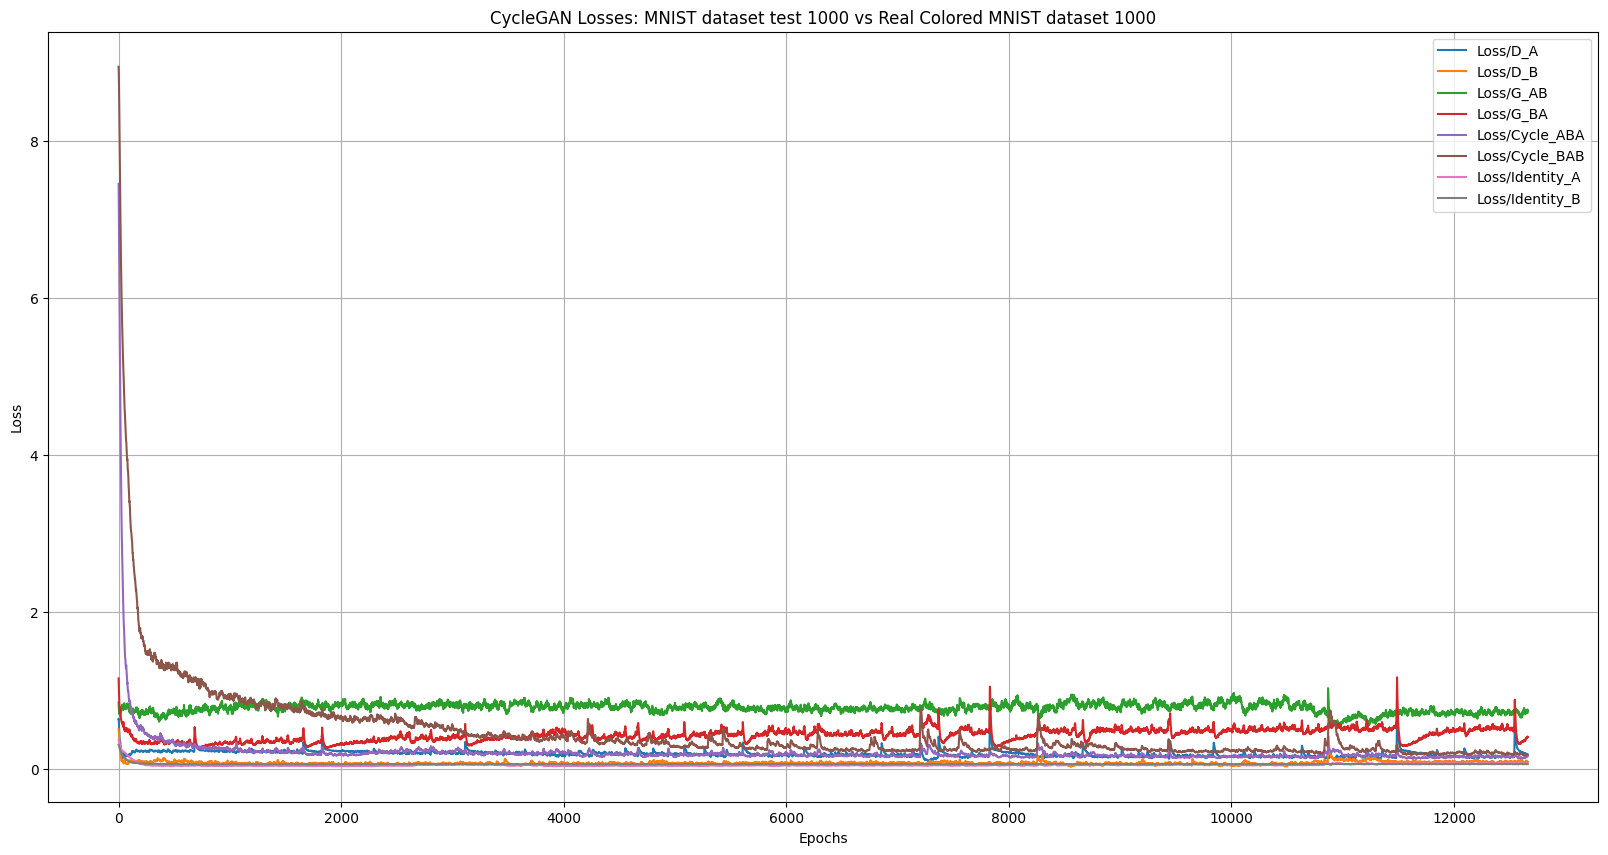

In [40]:
smoothed_losses_D_A = smooth_curve(losses_D_A)
smoothed_losses_D_B = smooth_curve(losses_D_B)
smoothed_losses_G_AB = smooth_curve(losses_G_AB)
smoothed_losses_G_BA = smooth_curve(losses_G_BA)
smoothed_losses_cycle_ABA = smooth_curve(losses_cycle_ABA)
smoothed_losses_cycle_BAB = smooth_curve(losses_cycle_BAB)
smoothed_losses_identity_A = smooth_curve(losses_identity_A)
smoothed_losses_identity_B = smooth_curve(losses_identity_B)

# Plot the smoothed losses
plt.figure(figsize=(20,10))
plt.plot(smoothed_losses_D_A, label='Loss/D_A')
plt.plot(smoothed_losses_D_B, label='Loss/D_B')
plt.plot(smoothed_losses_G_AB, label='Loss/G_AB')
plt.plot(smoothed_losses_G_BA, label='Loss/G_BA')
plt.plot(smoothed_losses_cycle_ABA, label='Loss/Cycle_ABA')
plt.plot(smoothed_losses_cycle_BAB, label='Loss/Cycle_BAB')
plt.plot(smoothed_losses_identity_A, label='Loss/Identity_A')
plt.plot(smoothed_losses_identity_B, label='Loss/Identity_B')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CycleGAN Losses: MNIST dataset test 1000 vs Real Colored MNIST dataset 1000')
plt.grid(True)
plt.savefig('losses_plot1_smoothed.png')  # Save the plot as an image
plt.show()

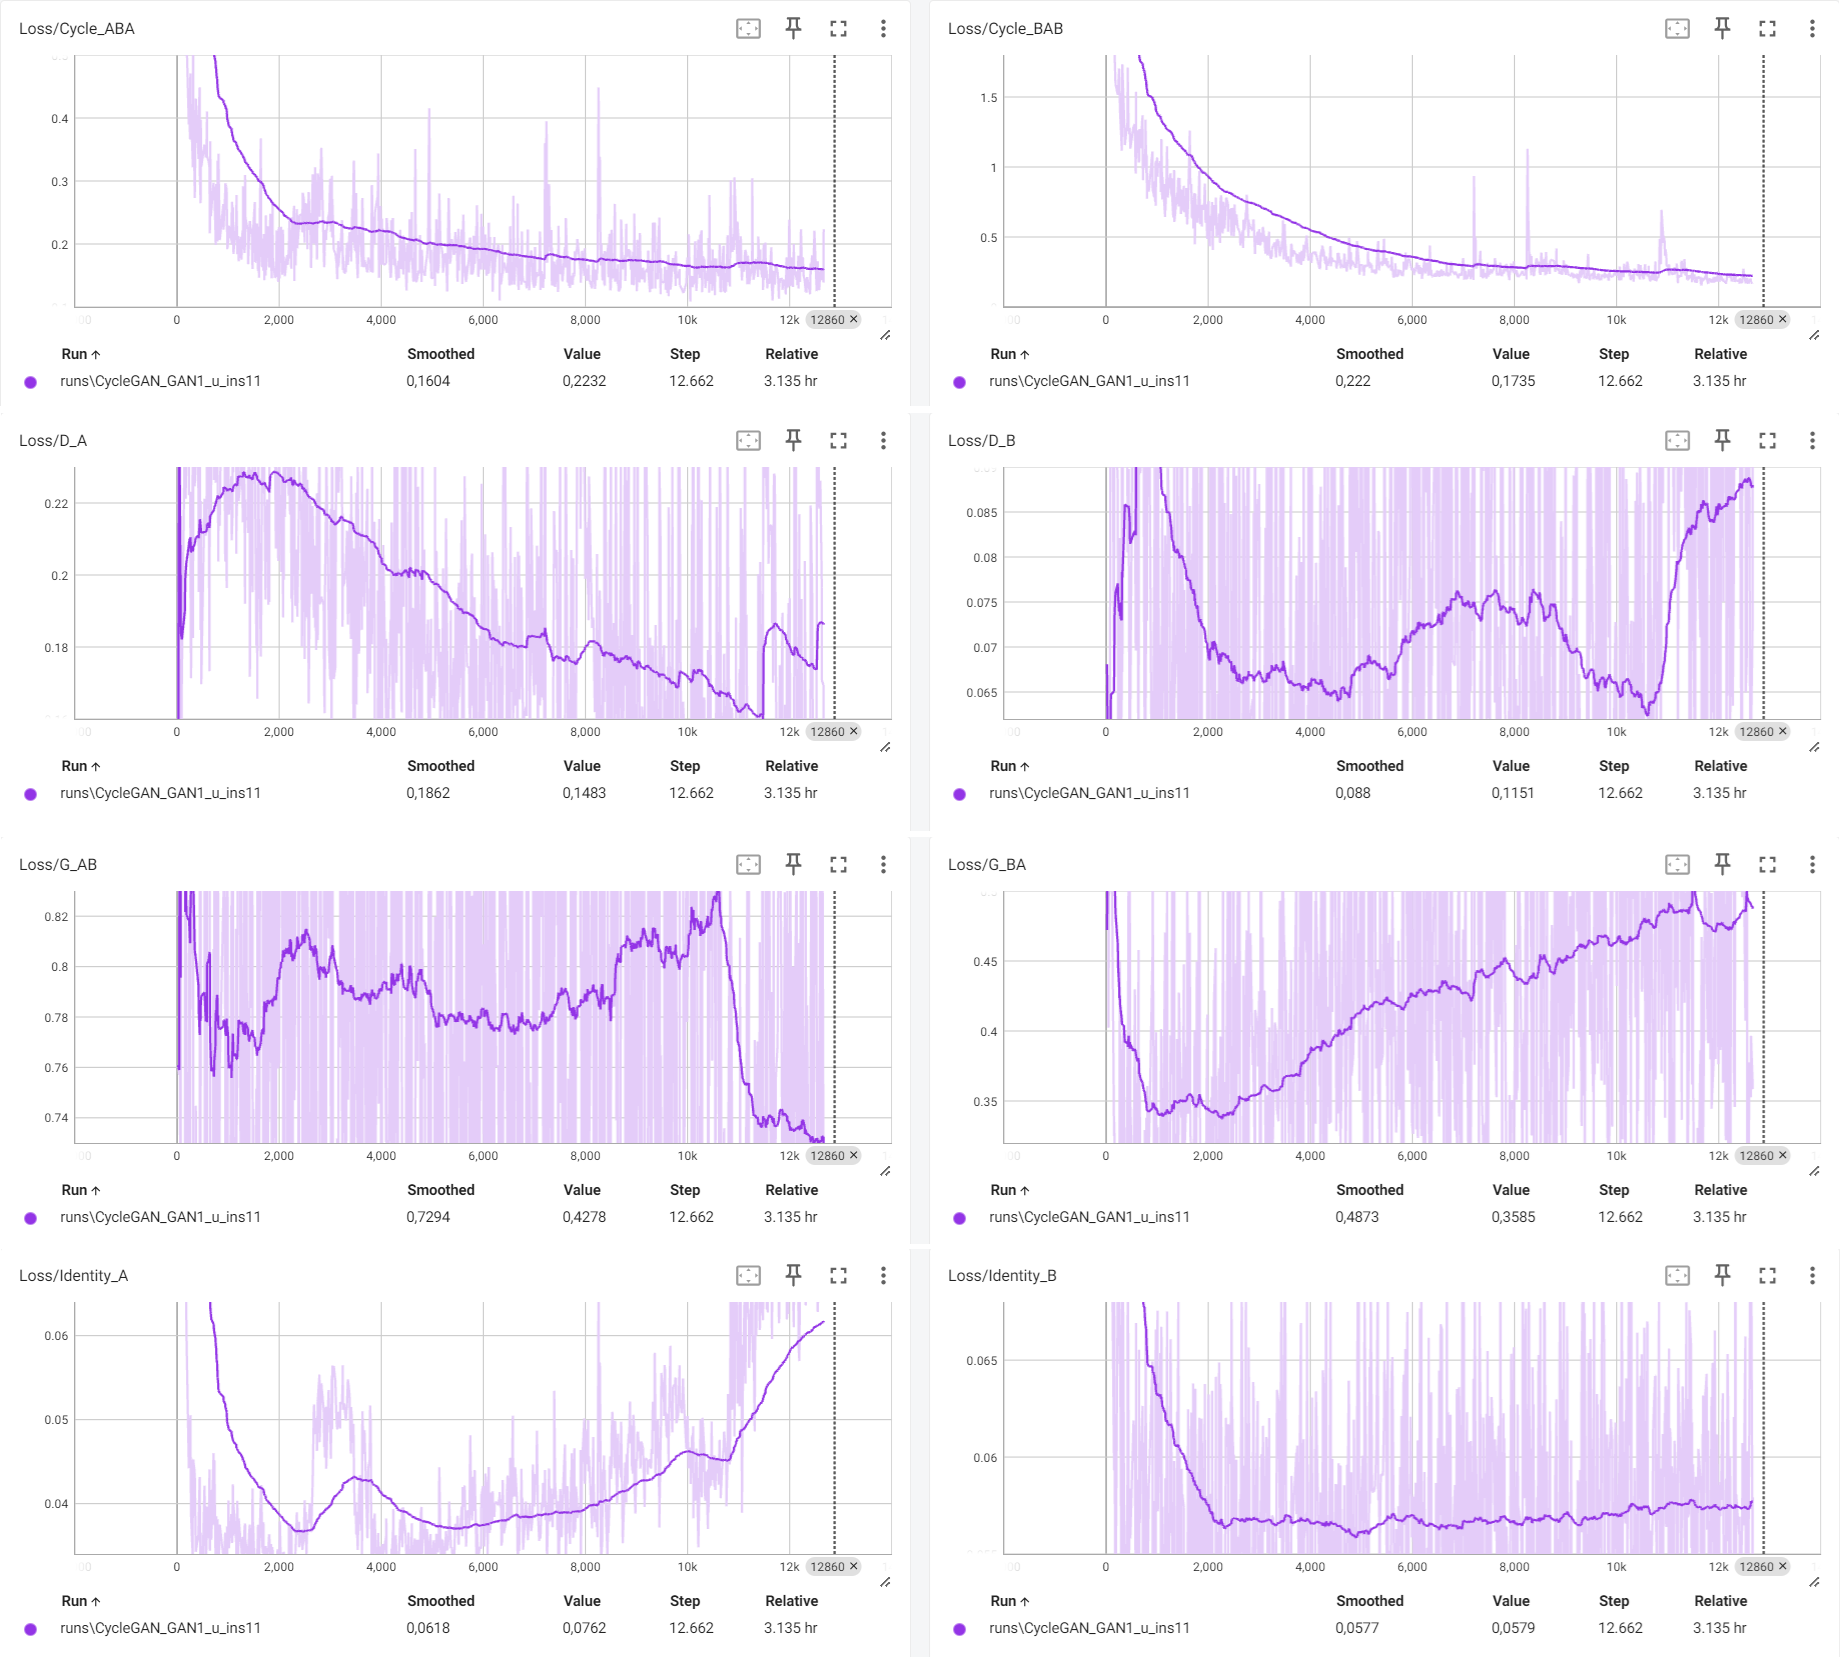

I want to highlight in this section that I tested several more extensive and deeper UNET architectures, changing optimizers, and so on, which, according to the literature, were much more efficient. However, due to the lack of memory, my training was not completed, even when I decreased the batch size. For this reason, I opted for a simpler model. Although my results are not good enough, one way to improve them was to use InstanceNorm layers (purple curves) instead of BatchNorm (green curves). This is because, according to the literature, InstanceNorm layers perform better in Style Transfer models, as can be seen in the TensorBoard plots. Additionally, I want to add that InstanceNorm is preferable over BatchNorm in CycleGAN models for Style Transfer because InstanceNorm normalizes the data in each image independently, which allows the preservation of the independence of each image in the dataset. This is crucial for Style Transfer tasks, where the unique relationship between the content and style of each individual image is more important than the common features of the dataset as a whole.

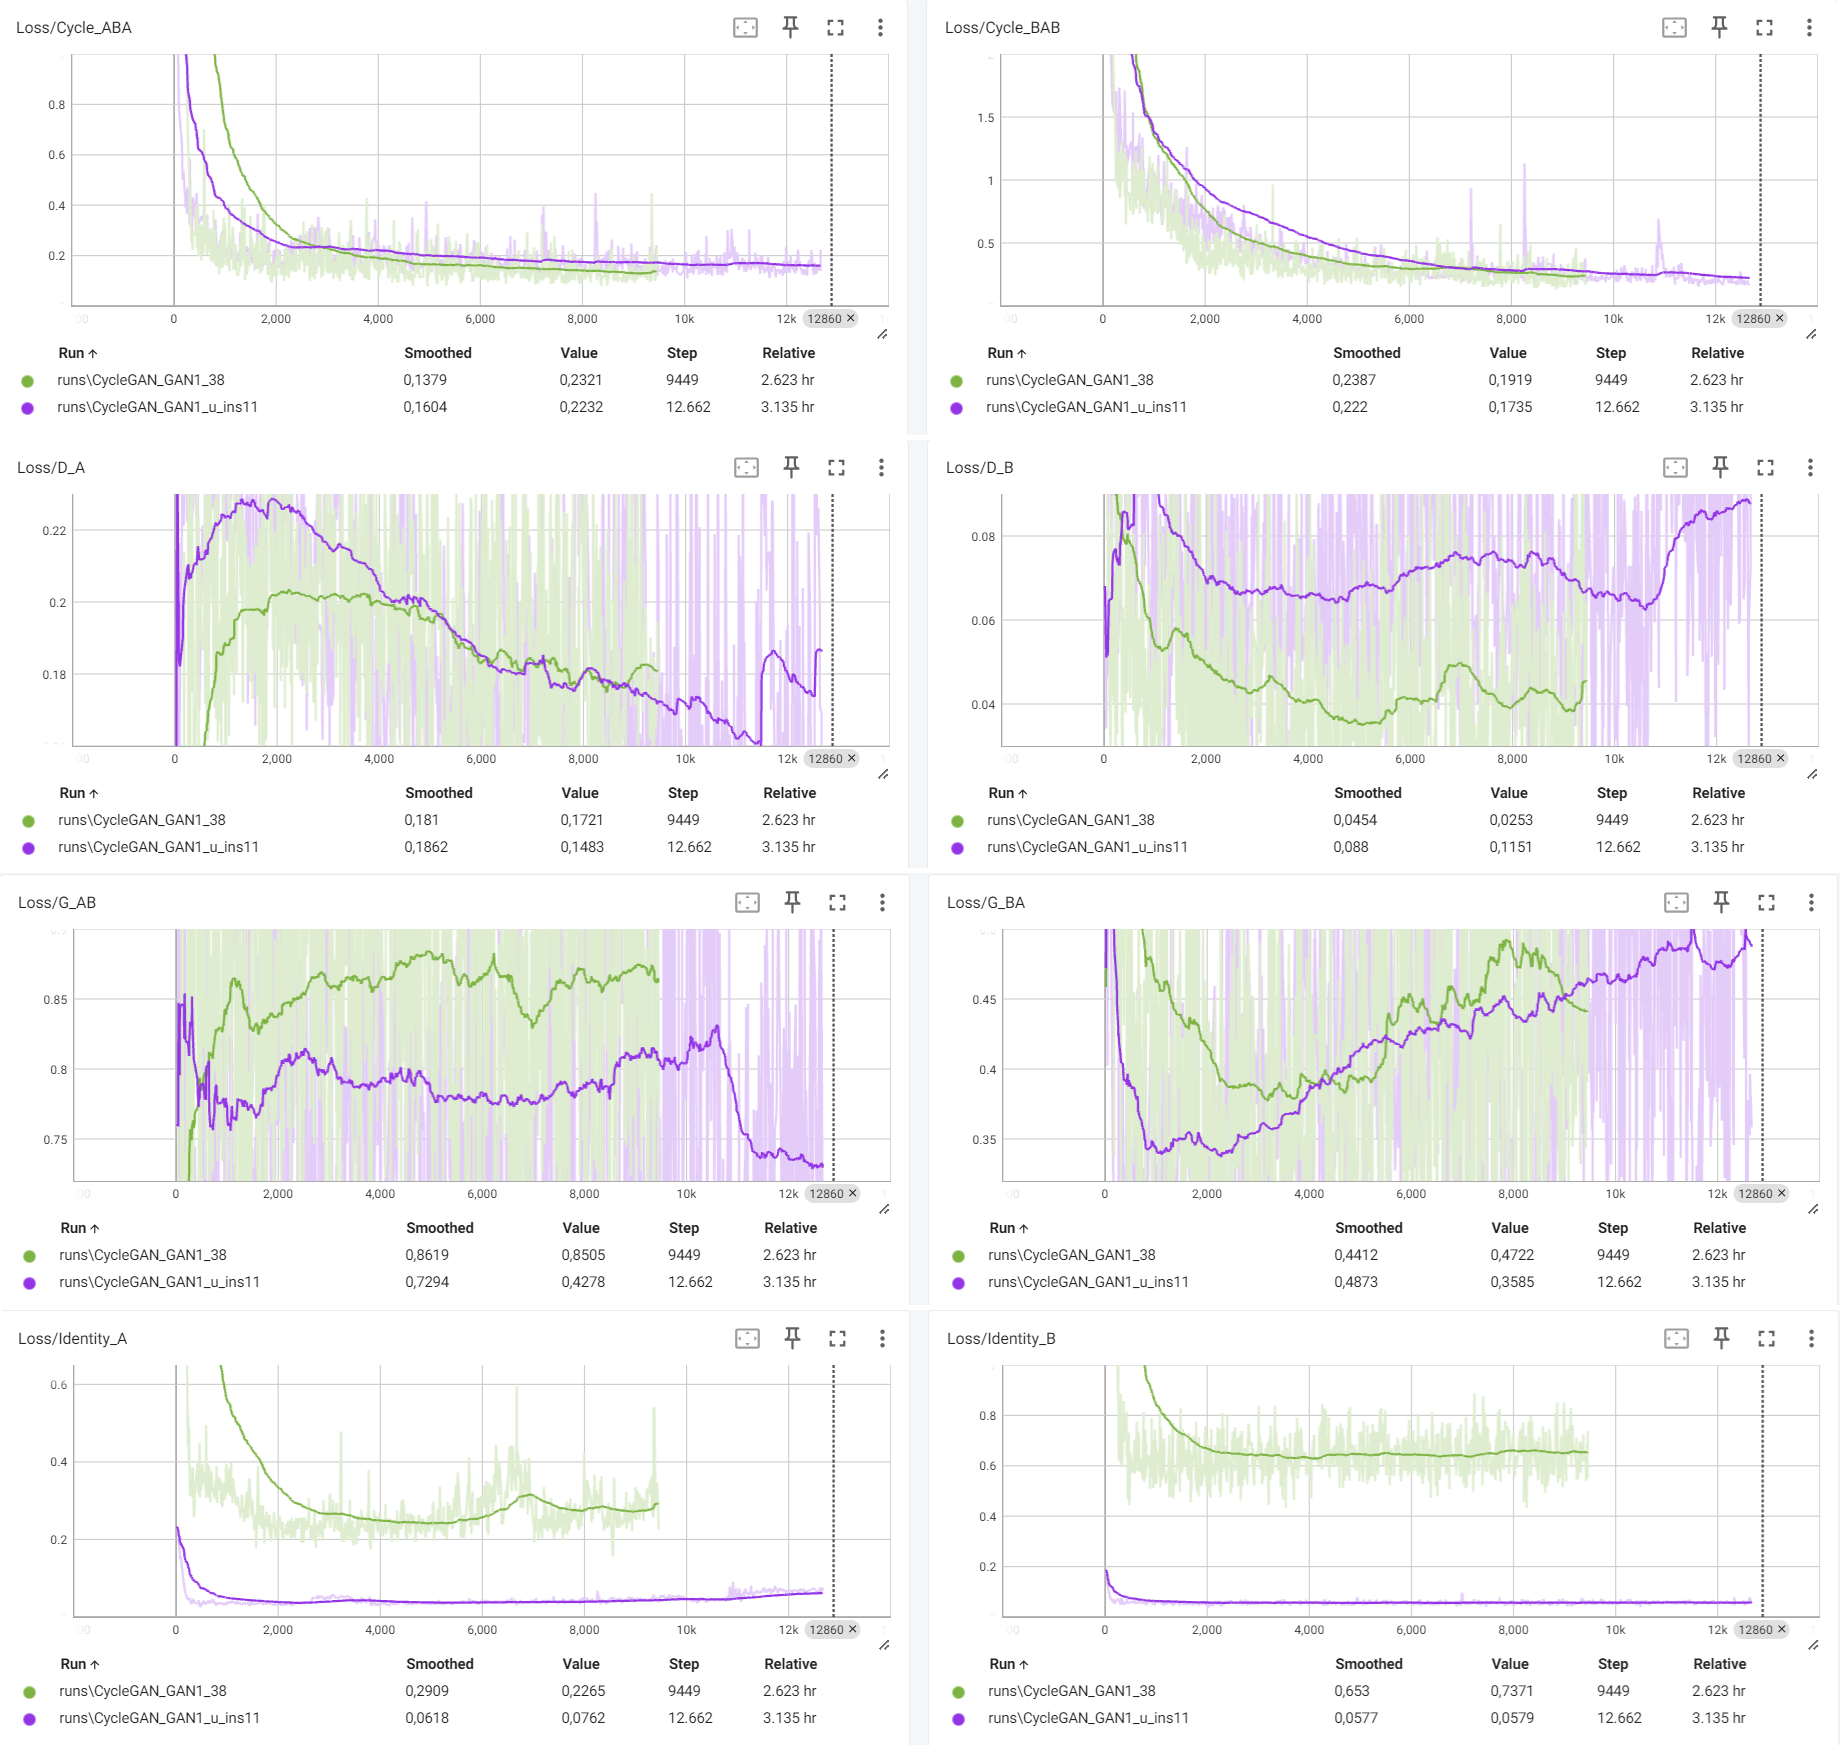

In [50]:
G_AB = UNetGenerator(in_channels=1, out_channels=3)
G_BA = UNetGenerator(in_channels=3, out_channels=1)

# Carga los pesos del modelo desde el checkpoint
checkpoint_path = './cyclegan_checkpoints_GAN1_u_ins11/cyclegan_checkpoint_201.pth'  
checkpoint = torch.load(checkpoint_path, map_location=device)
G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
G_BA.load_state_dict(checkpoint['G_BA_state_dict'])

G_AB = G_AB.to(device)
G_BA = G_BA.to(device)

# Pon el modelo en modo de evaluación
G_AB.eval()
G_BA.eval()

UNetGenerator(
  (down1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (down2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (bottleneck): ConvBlock(
    (conv): Sequential(
      (0): 

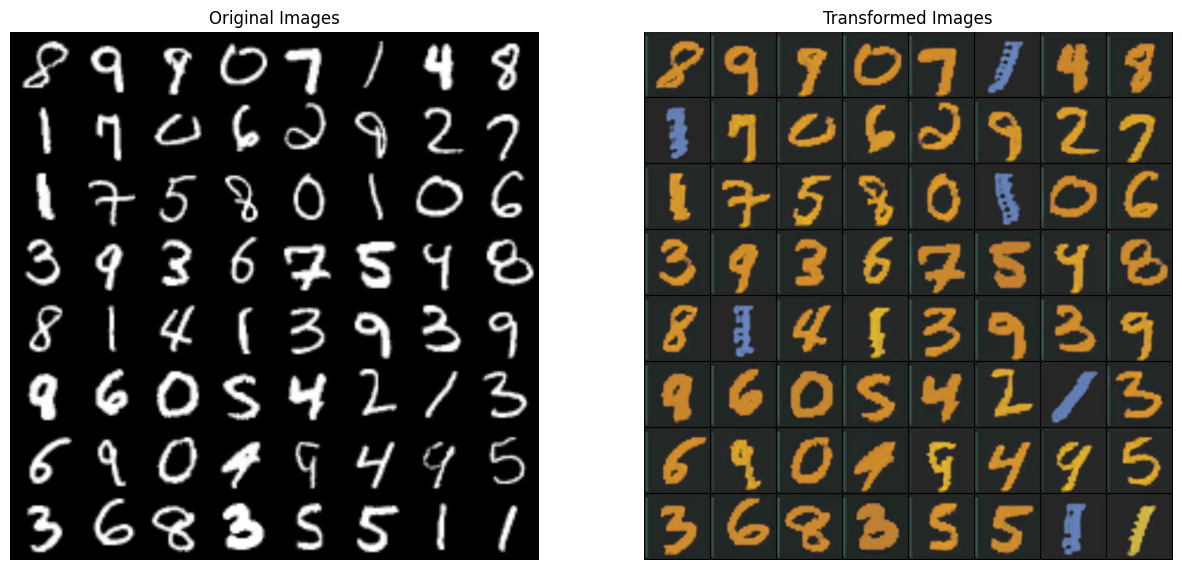

In [111]:
display_transformed_images(G_AB, dataloader_mnist, device, num_images=64)

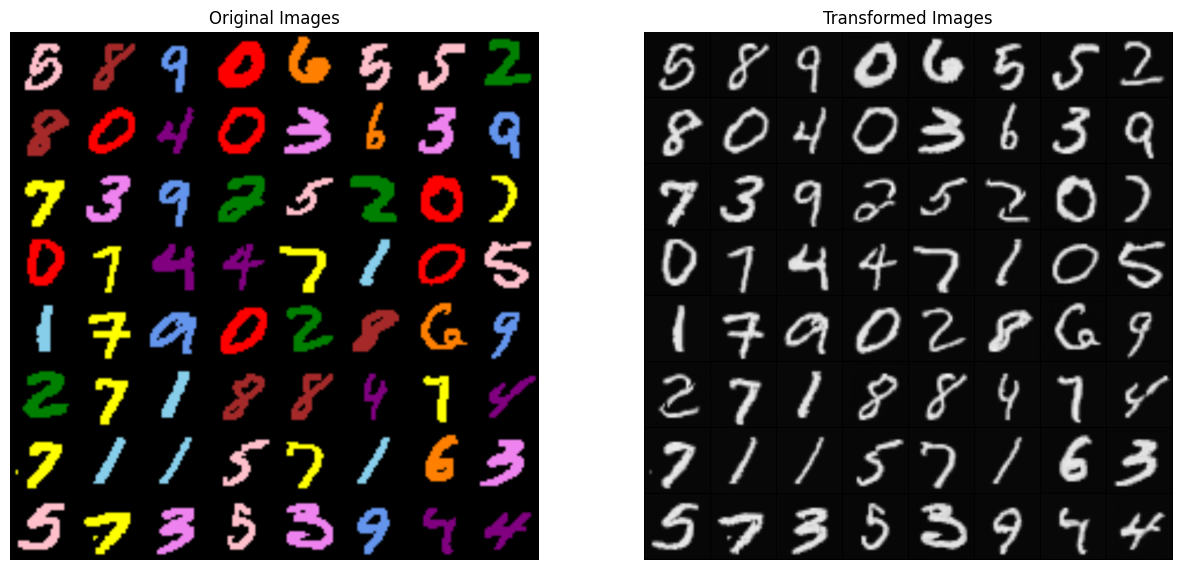

In [112]:
display_transformed_images(G_BA, dataloader_real, device, num_images=64)

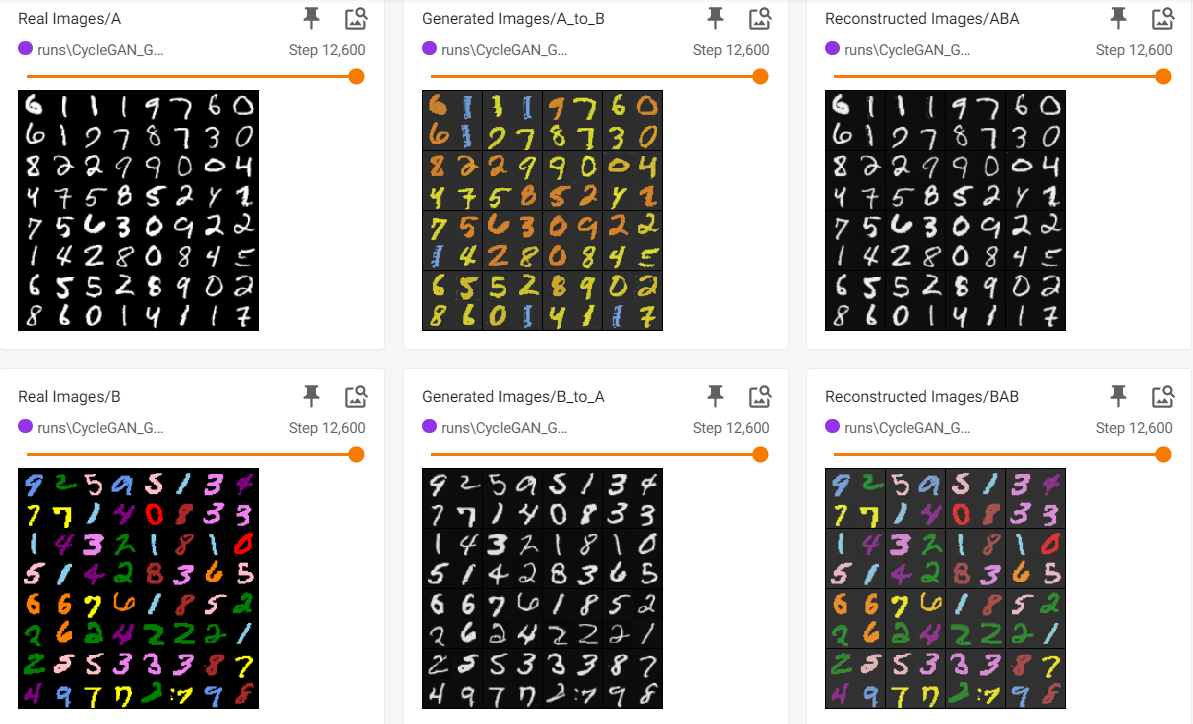

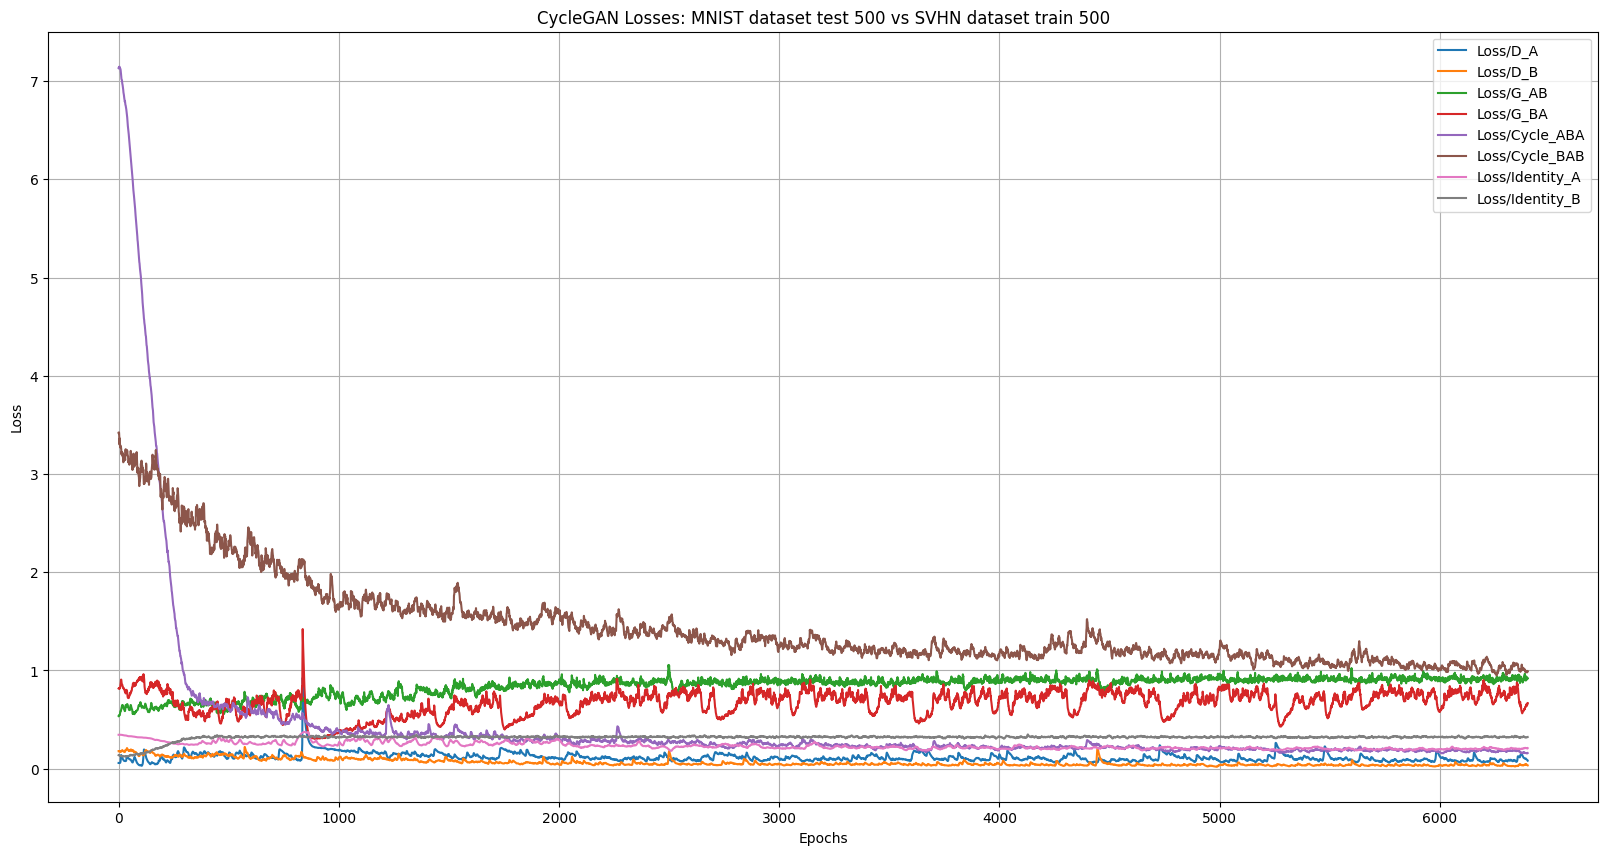

In [39]:
smoothed_losses_D_A_svhn = smooth_curve(losses_D_A_svhn)
smoothed_losses_D_B_svhn = smooth_curve(losses_D_B_svhn)
smoothed_losses_G_AB_svhn = smooth_curve(losses_G_AB_svhn)
smoothed_losses_G_BA_svhn = smooth_curve(losses_G_BA_svhn)
smoothed_losses_cycle_ABA_svhn = smooth_curve(losses_cycle_ABA_svhn)
smoothed_losses_cycle_BAB_svhn = smooth_curve(losses_cycle_BAB_svhn)
smoothed_losses_identity_A_svhn = smooth_curve(losses_identity_A_svhn)
smoothed_losses_identity_B_svhn = smooth_curve(losses_identity_B_svhn)

# Plot the smoothed losses
plt.figure(figsize=(20,10))
plt.plot(smoothed_losses_D_A_svhn, label='Loss/D_A')
plt.plot(smoothed_losses_D_B_svhn, label='Loss/D_B')
plt.plot(smoothed_losses_G_AB_svhn, label='Loss/G_AB')
plt.plot(smoothed_losses_G_BA_svhn, label='Loss/G_BA')
plt.plot(smoothed_losses_cycle_ABA_svhn, label='Loss/Cycle_ABA')
plt.plot(smoothed_losses_cycle_BAB_svhn, label='Loss/Cycle_BAB')
plt.plot(smoothed_losses_identity_A_svhn, label='Loss/Identity_A')
plt.plot(smoothed_losses_identity_B_svhn, label='Loss/Identity_B')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CycleGAN Losses: MNIST dataset test 500 vs SVHN dataset train 500')
plt.grid(True)
plt.savefig('losses_plot2_svhn_smoothed.png') 
plt.show()

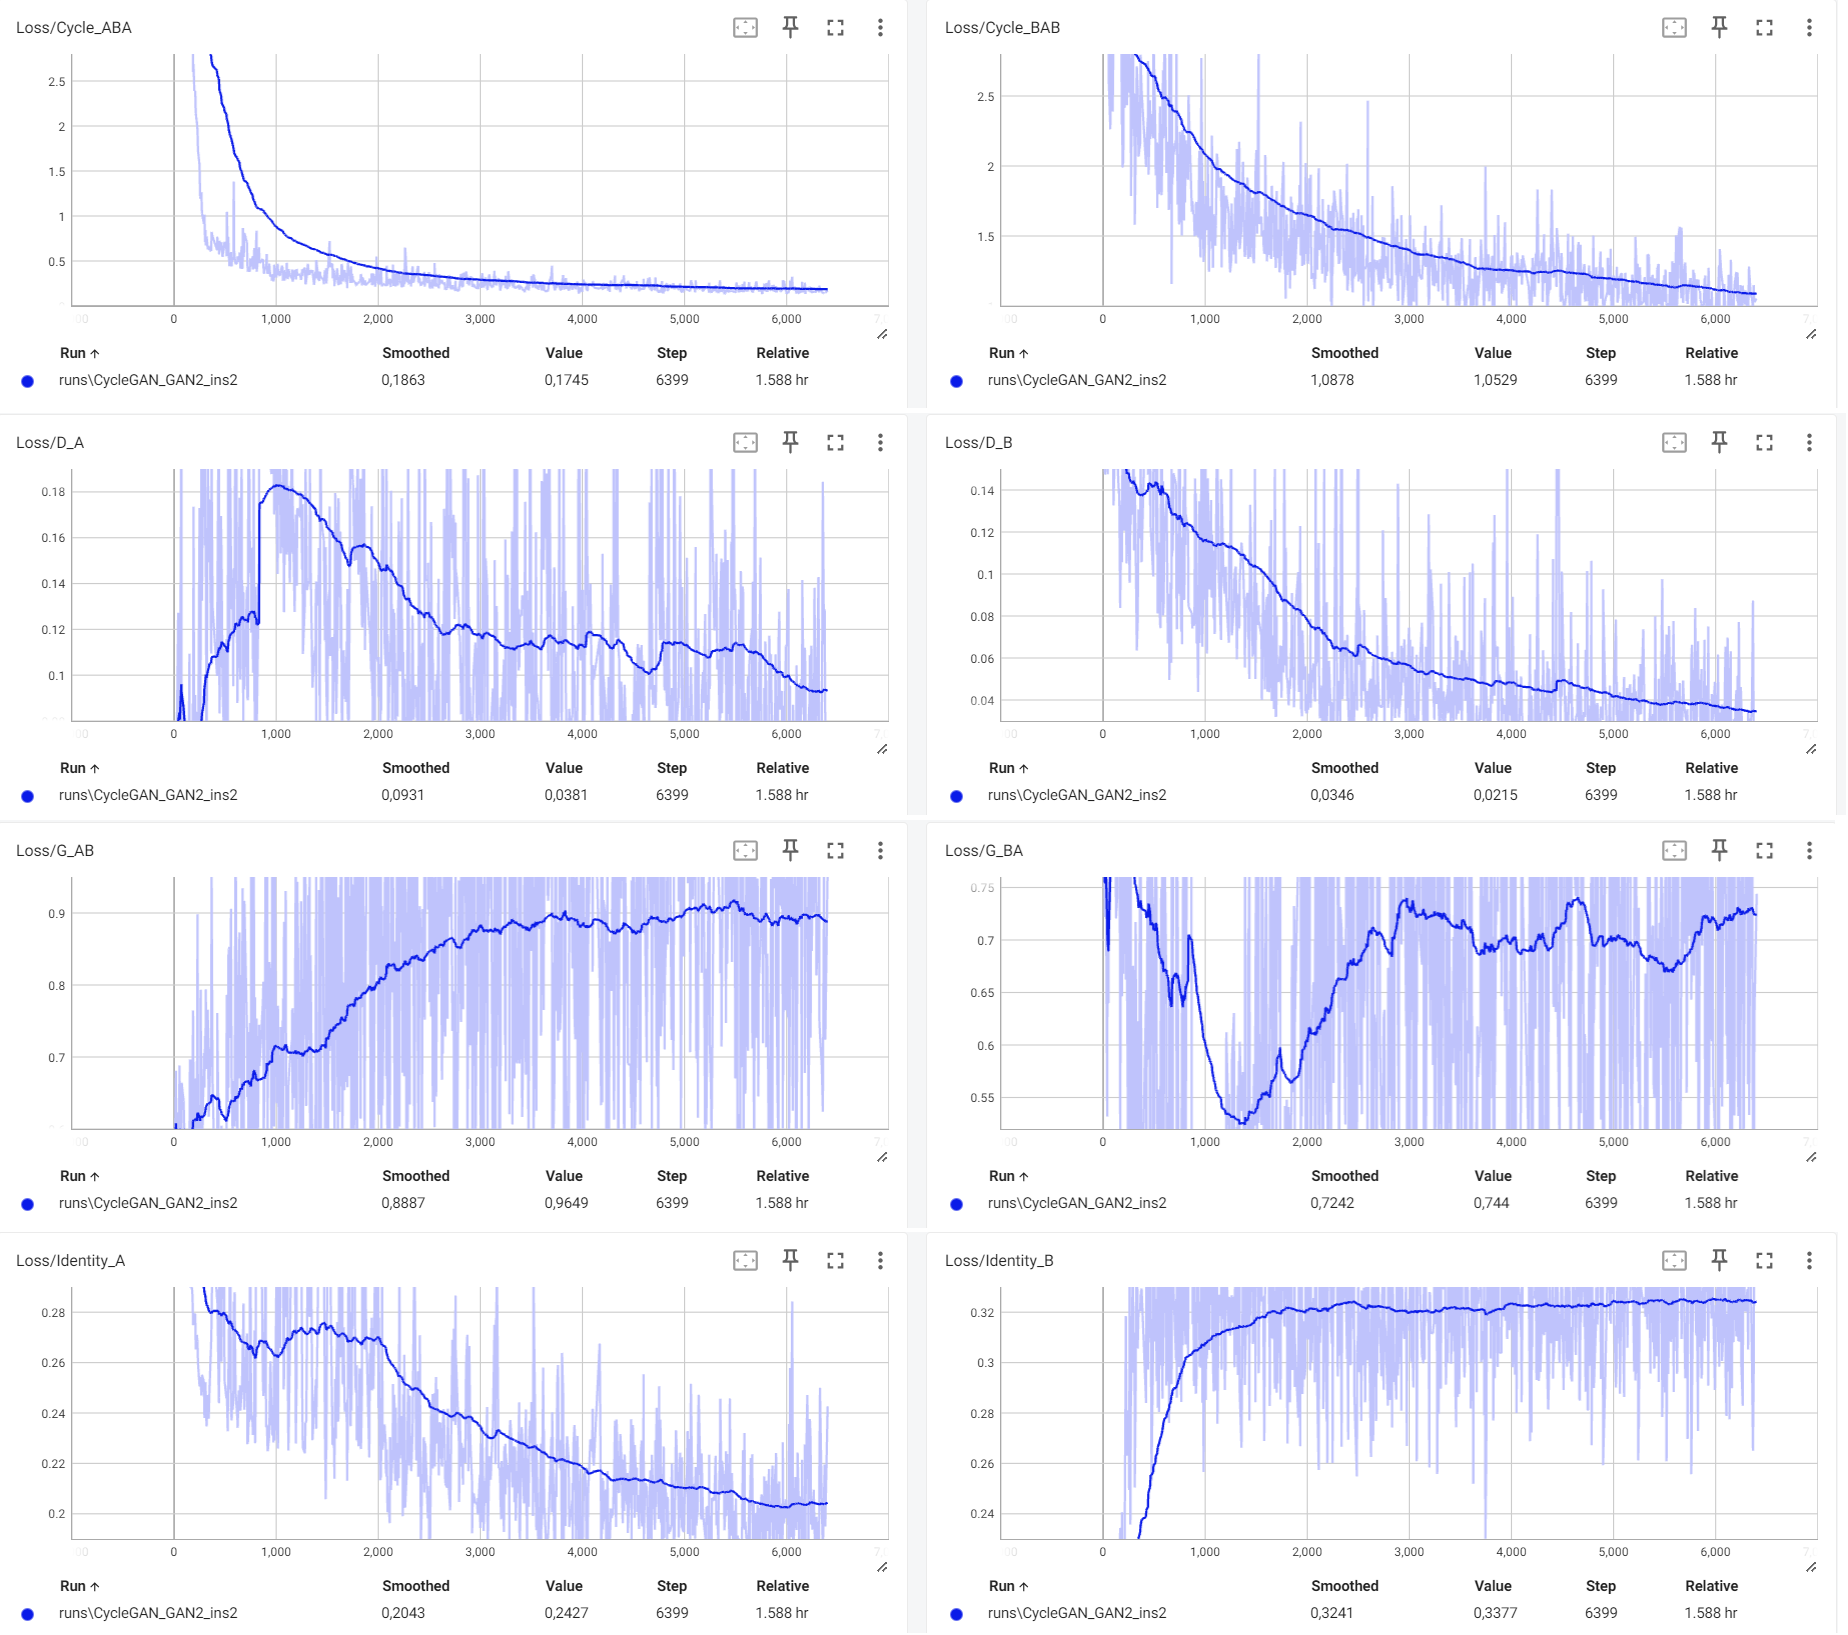

In [51]:
G_AB_svhn = UNetGenerator(in_channels=1, out_channels=3)
G_BA_svhn = UNetGenerator(in_channels=3, out_channels=1)

# Carga los pesos del modelo desde el checkpoint
checkpoint_path = './cyclegan_checkpoints_GAN2_ins2/cyclegan_checkpoint_200.pth'  
checkpoint = torch.load(checkpoint_path, map_location=device)
G_AB_svhn.load_state_dict(checkpoint['G_AB_state_dict'])
G_BA_svhn.load_state_dict(checkpoint['G_BA_state_dict'])

G_AB_svhn = G_AB_svhn.to(device)
G_BA_svhn = G_BA_svhn.to(device)

# Pon el modelo en modo de evaluación
G_AB_svhn.eval()
G_BA_svhn.eval()

UNetGenerator(
  (down1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (down2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (bottleneck): ConvBlock(
    (conv): Sequential(
      (0): 

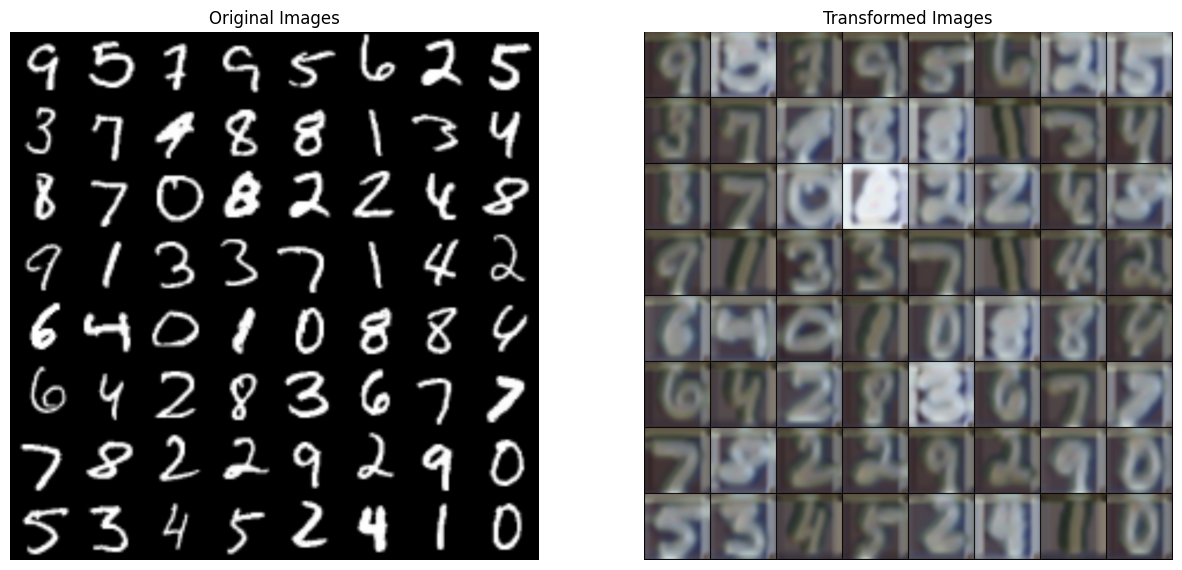

In [123]:
display_transformed_images(G_AB_svhn, dataloader_mnist_500, device, num_images=64)

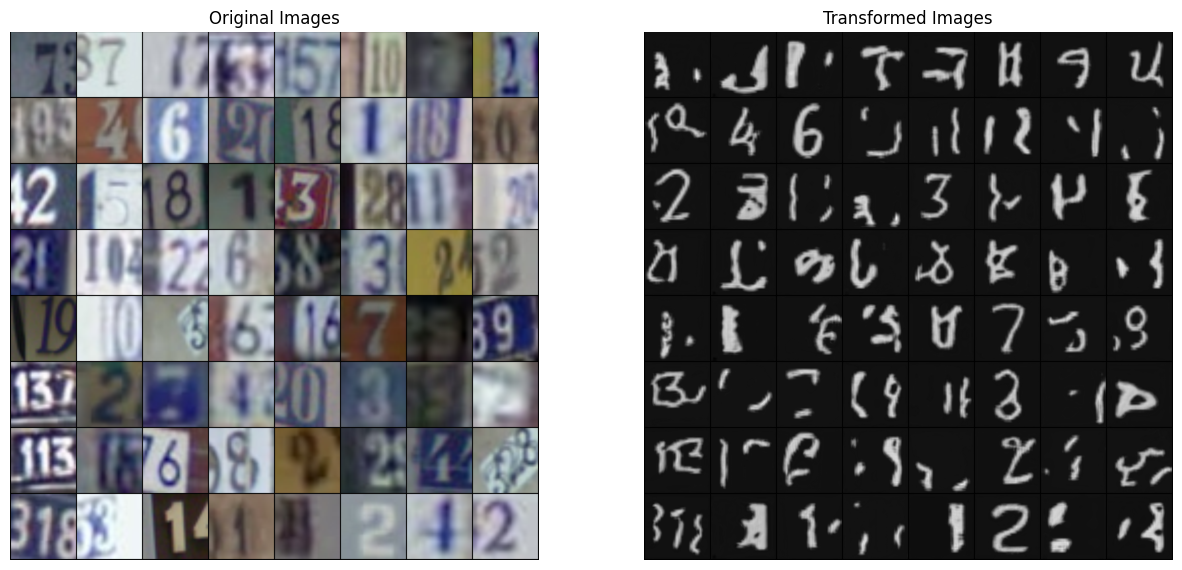

In [132]:
display_transformed_images(G_BA_svhn, dataloader_svhn_500, device, num_images=64)

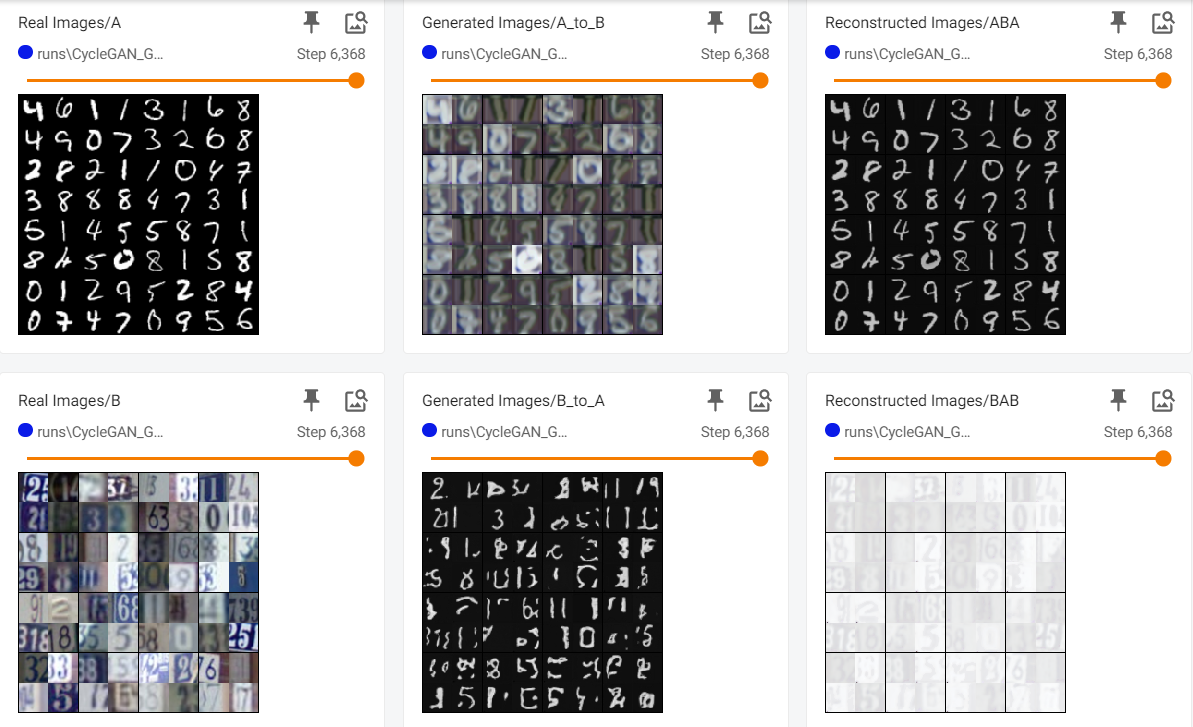

##### __6. Please compute the FID distance and comment the results between the generated and real samples:__

###### • Domain A: real colored MNIST (created by get_rgb) and domain B: generated colored from your Cycle-GAN

In [68]:
generated_images_B = []
G_AB.eval()
with torch.no_grad():
    for batch in dataloader_mnist:
        images = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)
        if G_AB.in_channels == 3 and images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        generated_images = G_AB(images)
        generated_images_B.append(generated_images.cpu())

generated_images_B = torch.cat(generated_images_B, 0)

We check if the images are normalized for the Inception model

In [69]:
dataiter = iter(generated_images_B)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -0.7816850543022156
Desviación estándar del lote: 0.5494877099990845
Mínimo valor en el lote: -1.1751435995101929
Máximo valor en el lote: 1.4569224119186401


In [70]:
generated_images_B.shape

torch.Size([1000, 3, 128, 128])

In [71]:
generated_images_B_resized = F.interpolate(generated_images_B, size=(299, 299), mode='bilinear', align_corners=False)

In [72]:
generated_images_B_resized.shape

torch.Size([1000, 3, 299, 299])

In [73]:
dataiter = iter(generated_images_B_resized)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -0.7816799283027649
Desviación estándar del lote: 0.5478666424751282
Mínimo valor en el lote: -1.1563441753387451
Máximo valor en el lote: 1.4528030157089233


In [74]:
dataiter = iter(images_real)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -1.1908841133117676
Desviación estándar del lote: 1.4421885013580322
Mínimo valor en el lote: -2.1179039478302
Máximo valor en el lote: 2.248908281326294


In [75]:
images_real.shape

torch.Size([1000, 3, 299, 299])

In [76]:
fid_value1 = compute_fid(images_real, generated_images_B_resized, model_inception, batch_size=64)
print(f"FID between Real colored MNIST and Generated colored from your Cycle-GAN: {fid_value1}")

FID between Real colored MNIST and Generated colored from your Cycle-GAN: 105.99910977539449


In [77]:
images_real_copy = images_real.clone()
generated_images_B_resized_copy =generated_images_B_resized.clone()

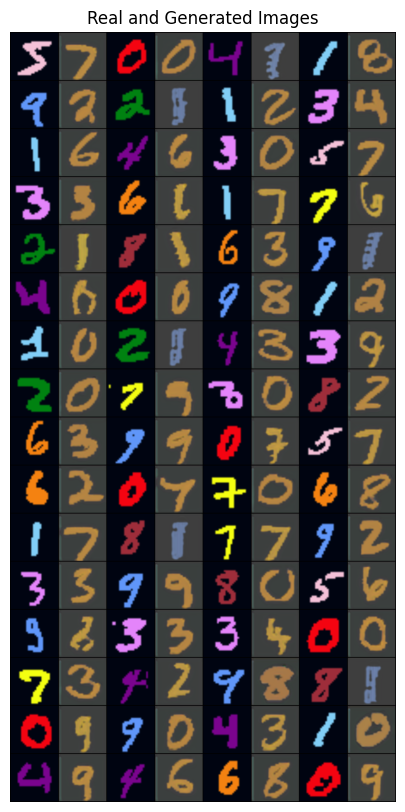

In [78]:
if images_real_copy.dim() == 3:
    images_real_copy = images_real_copy.unsqueeze(1)  

if images_real_copy.shape[1] == 1:
    images_real_copy = images_real_copy.repeat(1, 3, 1, 1)  

if generated_images_B_resized_copy.dim() == 3:
    generated_images_B_resized_copy = generated_images_B_resized_copy.unsqueeze(1) 

if generated_images_B_resized_copy.shape[1] == 1:
    generated_images_B_resized_copy = generated_images_B_resized_copy.repeat(1, 3, 1, 1)  

images_real_copy = F.interpolate(images_real_copy, size=(128, 128))
generated_images_B_resized_copy = F.interpolate(generated_images_B_resized_copy, size=(128, 128))

num_images = 64  
images_combined = torch.Tensor(num_images * 2, 3, 128, 128)  

for i in range(num_images):
    images_combined[i * 2] = images_real_copy[i] 
    images_combined[i * 2 + 1] = generated_images_B_resized_copy[i] 

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Real and Generated Images')
plt.imshow(np.transpose(vutils.make_grid(images_combined, padding=2, normalize=True, nrow=8), (1, 2, 0)))
plt.show()

###### • Domain A: first 500 images of training set of original MNIST and domain B: first 500 images of training set of SVHN

In [79]:
mnist_train_ori = datasets.MNIST(root ='./data_ori', train =True , download = True)
mnist_tra_ori500_first = Subset(mnist_train_ori, range(500))
dataset_mnist_tra_ori500_first = MNISTColoredDataset(mnist_tra_ori500_first) #DIMENSION Inception
mnist_tra_ori500_first_loader = DataLoader(dataset_mnist_tra_ori500_first, batch_size=64, shuffle=True)
images_tra_ori500_first = get_all_images(mnist_tra_ori500_first_loader).to(device)

In [80]:
images_tra_ori500_first.shape

torch.Size([500, 3, 299, 299])

In [81]:
dataiter = iter(mnist_tra_ori500_first_loader)
images = next(dataiter)

print(f"Shape of images: {images.shape}")
print(f"Max value in images: {images.max()}")
print(f"Min value in images: {images.min()}")
print(f"Mean of images: {images.mean(dim=[0,2,3])}")  # Promedio por canal
print(f"Std of images: {images.std(dim=[0,2,3])}")  # Desviación estándar por canal

Shape of images: torch.Size([64, 3, 299, 299])
Max value in images: 2.640000104904175
Min value in images: -2.1179039478302
Mean of images: tensor([-1.5471, -1.4521, -1.2235])
Std of images: tensor([1.2581, 1.2861, 1.2804])


In [82]:
dataiter = iter(images_tra_ori500_first)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -1.4821839332580566
Desviación estándar del lote: 1.2237974405288696
Mínimo valor en el lote: -2.1179039478302
Máximo valor en el lote: 2.640000104904175


Values are within normal range

In [83]:
images_tra_ori500_svhn = images_svhn_500_train

In [84]:
images_tra_ori500_svhn.shape

torch.Size([500, 3, 299, 299])

In [85]:
dataiter = iter(images_tra_ori500_svhn)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f"Shape of images: {images.shape}")
print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Shape of images: torch.Size([3, 299, 299])
Media del lote: -0.8840353488922119
Desviación estándar del lote: 0.41557636857032776
Mínimo valor en el lote: -1.9124069213867188
Máximo valor en el lote: -0.14495795965194702


In [86]:
fid_value3 = compute_fid(images_tra_ori500_first, images_tra_ori500_svhn, model_inception, batch_size=64)
print(f"FID between First 500img of training set of original MNIST and First 500img of training set of original SVHN: {fid_value3}")

FID between First 500img of training set of original MNIST and First 500img of training set of original SVHN: 224.01519777793803


In [87]:
images_tra_ori500_first_copy = images_tra_ori500_first.clone()
images_tra_ori500_svhn_copy =images_tra_ori500_svhn.clone()

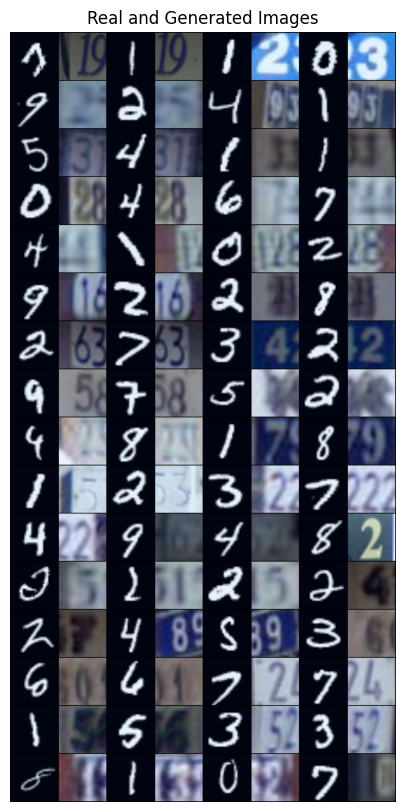

In [88]:
if images_tra_ori500_first_copy.dim() == 3:
    images_tra_ori500_first_copy = images_tra_ori500_first_copy.unsqueeze(1)  

if images_tra_ori500_first_copy.shape[1] == 1:
    images_tra_ori500_first_copy = images_tra_ori500_first_copy.repeat(1, 3, 1, 1)  

if images_tra_ori500_svhn_copy.dim() == 3:
    images_tra_ori500_svhn_copy  = images_tra_ori500_svhn_copy.unsqueeze(1) 

if images_tra_ori500_svhn_copy.shape[1] == 1:
    images_tra_ori500_svhn_copy  = images_tra_ori500_svhn_copy.repeat(1, 3, 1, 1)  

images_tra_ori500_first_copy = F.interpolate(images_tra_ori500_first_copy, size=(128, 128))
images_tra_ori500_svhn_copy  = F.interpolate(images_tra_ori500_svhn_copy , size=(128, 128))

num_images = 64  
images_combined = torch.Tensor(num_images * 2, 3, 128, 128)  

for i in range(num_images):
    images_combined[i * 2] = images_tra_ori500_first_copy[i] 
    images_combined[i * 2 + 1] = images_tra_ori500_svhn_copy[i] 

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Real and Generated Images')
plt.imshow(np.transpose(vutils.make_grid(images_combined, padding=2, normalize=True, nrow=8), (1, 2, 0)))
plt.show()

###### • Domain A: first 500 images of training set of SVHN and domain B: generated SVHN numbers with your CycleGAN (500 first samples of MNIST training set)

In [89]:
images_tra_ori500_svhn = images_svhn_500_train #ya tiene dimension de inception 

In [90]:
batch_size = 16

# Load MNIST dataset 1000
transform1 = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar para coincidir con la dimensión de entrada de U-Net
    transforms.ToTensor(),  # Convertir de PIL.Image a Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizar con media=0.5, desvío=0.5
])

mnist_train_ori = datasets.MNIST(root='./data_ori', train=True, download=True, transform=transform1)
mnist_tra_ori500_first = Subset(mnist_train_ori, range(500))  # Usa mnist_train_ori, no dataset_mnist_test
dataloader_mnist500 = DataLoader(mnist_tra_ori500_first, batch_size=batch_size, shuffle=True)

In [91]:
generated2_images_B = []
G_AB_svhn.eval()
with torch.no_grad():
    for batch in dataloader_mnist500:
        images = batch[0].to(device)  # Asegúrate de que batch[0] ya son tensores
        # Si es necesario, realiza la conversión aquí
        if G_AB_svhn.in_channels == 3 and images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        generated2_images = G_AB_svhn(images)
        generated2_images_B.append(generated2_images.cpu())

In [92]:
dataiter = iter(generated2_images_B)
images= next(dataiter)

mean = images.mean()
std = images.std()

print(f'Media del lote: {mean.item()}')
print(f'Desviación estándar del lote: {std.item()}')

min_value = images.min().item()
max_value = images.max().item()

print(f'Mínimo valor en el lote: {min_value}')
print(f'Máximo valor en el lote: {max_value}')

Media del lote: -0.4206590950489044
Desviación estándar del lote: 0.24449694156646729
Mínimo valor en el lote: -1.0082228183746338
Máximo valor en el lote: 0.23164816200733185


In [93]:
generated2_images_B[0].shape

torch.Size([16, 3, 128, 128])

In [94]:
generated2_images_B_tensors = [t for t in generated2_images_B]
generated2_images_B_concat = torch.cat(generated2_images_B_tensors, dim=0)
print(f"Forma del tensor concatenado: {generated2_images_B_concat.shape}")

Forma del tensor concatenado: torch.Size([500, 3, 128, 128])


In [95]:
transform_generated = transforms.Compose([
     transforms.Resize((299, 299)),  # Redimensionar a 299x299 para InceptionV3
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar como SVHN
])

# Aplicar las transformaciones a las imágenes generadas
generated2_images_B_normalized = torch.stack([transform_generated(img) for img in generated2_images_B_concat])

dataiter = iter(generated2_images_B_normalized)
images = next(dataiter)
print('Estadísticas de las imágenes generadas normalizadas:')
print(f'Media del lote: {images.mean().item()}')
print(f'Desviación estándar del lote: {images.std().item()}')
print(f'Mínimo valor en el lote: {images.min().item()}')
print(f'Máximo valor en el lote: {images.max().item()}')

C:\Users\ksevi\anaconda3\envs\ML_styleTransfer\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Estadísticas de las imágenes generadas normalizadas:
Media del lote: -0.09894474595785141
Desviación estándar del lote: 0.6988338232040405
Mínimo valor en el lote: -1.3704479932785034
Máximo valor en el lote: 1.785969614982605


In [96]:
generated2_images_B_normalized.shape

torch.Size([500, 3, 299, 299])

In [97]:
images_tra_ori500_svhn.shape

torch.Size([500, 3, 299, 299])

In [98]:
# Calcular el FID entre images_tra_ori500_svhn y generated2_images_B_normalized
fid_value4 = compute_fid(images_tra_ori500_svhn, generated2_images_B_normalized, model_inception, batch_size=64)
print(f"FID entre SVHN real y SVHN generado con Cycle-GAN: {fid_value4}")

FID entre SVHN real y SVHN generado con Cycle-GAN: 202.08099494658111


In [99]:
generated2_images_B_normalized_cp = generated2_images_B_normalized.clone()
images_tra_ori500_svhn_cp = images_tra_ori500_svhn.clone()

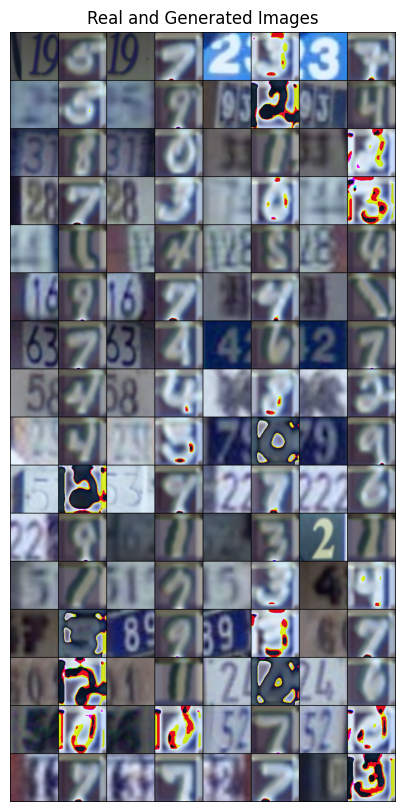

In [100]:
if images_tra_ori500_svhn_cp.dim() == 3:
    images_tra_ori500_svhn_cp = images_tra_ori500_svhn_cp.unsqueeze(1)  

if images_tra_ori500_svhn_cp.shape[1] == 1:
    images_tra_ori500_svhn_cp = images_tra_ori500_svhn_cp.repeat(1, 3, 1, 1)  

if generated2_images_B_normalized_cp.dim() == 3:
    generated2_images_B_normalized_cp = generated2_images_B_normalized_cp.unsqueeze(1) 

if generated2_images_B_normalized_cp.shape[1] == 1:
    generated2_images_B_normalized_cp = generated2_images_B_normalized_cp.repeat(1, 3, 1, 1)  

images_tra_ori500_svhn_cp = F.interpolate(images_tra_ori500_svhn_cp, size=(128, 128))
generated2_images_B_normalized_cp = F.interpolate(generated2_images_B_normalized_cp, size=(128, 128))

num_images = 64  
images_combined = torch.Tensor(num_images * 2, 3, 128, 128)  

for i in range(num_images):
    images_combined[i * 2] = images_tra_ori500_svhn_cp[i] 
    images_combined[i * 2 + 1] = generated2_images_B_normalized_cp[i] 

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Real and Generated Images')
plt.imshow(np.transpose(vutils.make_grid(images_combined, padding=2, normalize=True, nrow=8), (1, 2, 0)))
plt.show()

# Part IV [Bonus Points] - Data Augmentation for Classification


###### Describe and comment the steps of how you would employ this style transfer to improve the accuracy of your classifiers seen in Part II. Please comment in the context of limited number of annotated samples in one domain. Justify and discuss your steps for training your classifiers

To enhance classifier accuracy in the face of limited annotated samples, I aim to employ style transfer between MNIST and SVHN datasets for data augmentation. By generating a diverse set of training images that merge styles from both datasets, I anticipate boosting the model's generalization capability. I plan to adjust the ResNet-18 model to fit our classification needs, specifically by modifying its final layer to classify digits 0 to 9. Training will involve a mix of original and stylized images, utilizing categorical cross-entropy and the Adam optimizer to refine the learning process. Balancing the dataset and fine-tuning based on performance will be key. This strategy is expected to significantly improve the accuracy of digit classification by introducing a broader range of visual features for the model to learn from.

<div>
<img src='generator_A_GANS1.gif' width="300"/>
</div>

<div>
<img src="generator_B_GANS1.gif" width="300"/>
</div>

<div>
<img src="generator_A_GANS2.gif" width="300"/>
</div>

<div>
<img src="generator_B_GANS2.gif" width="300"/>
</div>